# Решающее дерево(классификатор)

## Импорт библиотек

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

import missingno as msno

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

## EDA

In [2]:
df = pd.read_csv('../frameworks-labs_nm/spaceship-titanic/train.csv')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
df.shape

(8693, 14)

In [6]:
df['Transported'].value_counts()

Transported
True     4378
False    4315
Name: count, dtype: int64

Видим что классы сбалансированы, значит можем использовать accuracy.

Заменим true и false на 1 и 0 соответственно

In [3]:
df[['Transported', 'CryoSleep', 'VIP']] = df[['Transported', 'CryoSleep', 'VIP']].apply(lambda col: col.map(lambda x: 1 if x is True else (0 if x is False else x)))

In [18]:
df['Transported'].value_counts()

Transported
1    4378
0    4315
Name: count, dtype: int64

Посмотрим на категориальные и числовые признаки

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   float64
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   float64
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   int64  
dtypes: float64(8), int64(1), object(5)
memory usage: 950.9+ KB


In [20]:
df.describe()

,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
count,8476.000000,8514.000000,8490.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8693.000000
mean,0.358306,28.827930,0.023439,224.687617,458.077203,173.729169,311.138778,304.854791,0.503624
std,0.479531,14.489021,0.151303,666.717663,1611.489240,604.696458,1136.705535,1145.717189,0.500016
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,38.000000,0.000000,47.000000,76.000000,27.000000,59.000000,46.000000,1.000000
max,1.000000,79.000000,1.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000


In [21]:
df.describe(include='object')

,PassengerId,HomePlanet,Cabin,Destination,Name
count,8693,8492,8494,8511,8493
unique,8693,3,6560,3,8473
top,0001_01,Earth,G/734/S,TRAPPIST-1e,Gollux Reedall
freq,1,4602,8,5915,2


Теперь займемся обработкой пропусков

In [22]:
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

<Axes: >

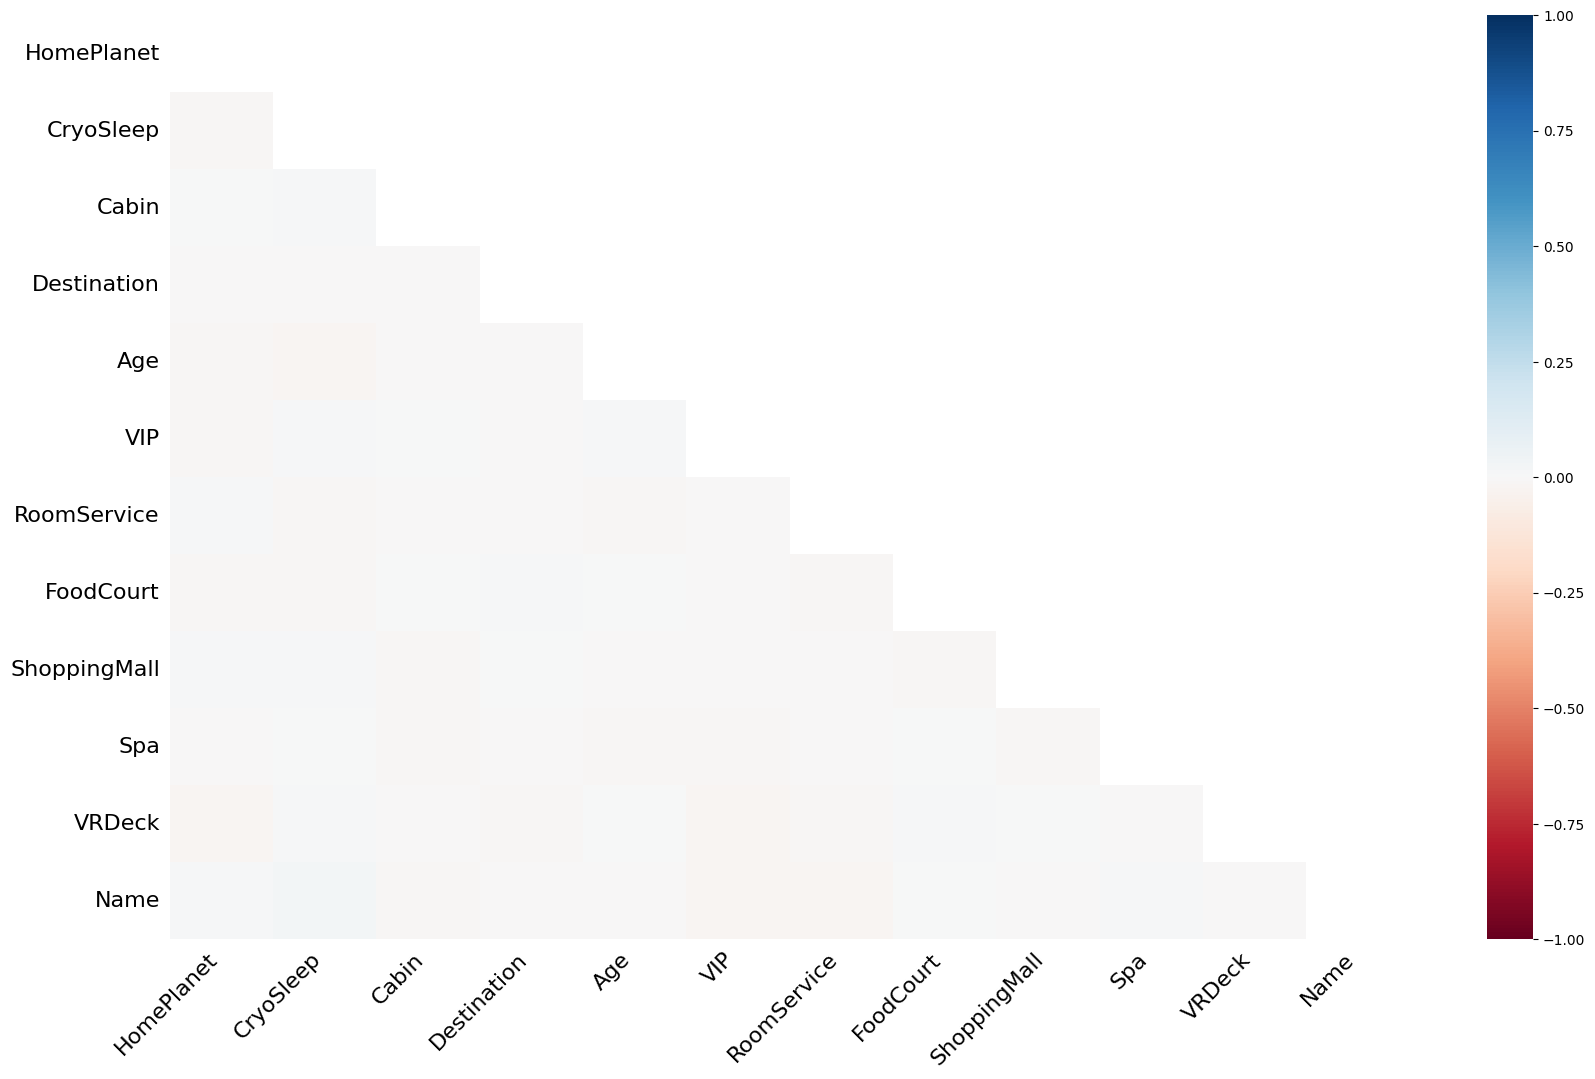

In [23]:
msno.heatmap(df)


Видим, что пропуски никак не коррелируют между собой, значит можем использовать стандартные методы их заполнения. Теперь посмотрим на них детальнее

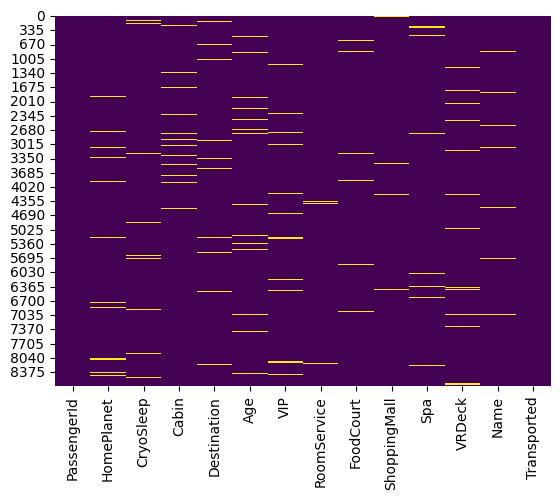

In [24]:

sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.show()

Итак по тепловой карте можем сделать предположение:
1) Пассажиры, которые находятся в криосне не совершали покупок в различных сервисах и как следствие пропуски у пассажиров, где CryoSleep == True мы должны заполнить 0.


In [20]:
df[(df['CryoSleep'] == 1) & (df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']]).isna().any(axis=1)]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
7,0006_02,Earth,1.0,G/0/S,TRAPPIST-1e,28.0,0.0,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,1
10,0008_02,Europa,1.0,B/1/P,TRAPPIST-1e,34.0,0.0,0.0,0.0,NaN,0.0,0.0,Altardr Flatic,1
23,0020_03,Earth,1.0,E/0/S,55 Cancri e,29.0,0.0,0.0,0.0,NaN,0.0,0.0,Mollen Mcfaddennon,0
25,0020_05,Earth,1.0,E/0/S,PSO J318.5-22,1.0,0.0,NaN,0.0,0.0,0.0,0.0,Mael Brantuarez,0
28,0024_01,Europa,1.0,C/2/S,TRAPPIST-1e,62.0,0.0,0.0,0.0,NaN,0.0,0.0,Penton Fullided,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8600,9179_03,Earth,1.0,G/1494/P,PSO J318.5-22,18.0,0.0,0.0,0.0,NaN,0.0,0.0,Darley Tranciams,0
8607,9186_01,Mars,1.0,F/1878/P,TRAPPIST-1e,2.0,0.0,0.0,0.0,NaN,0.0,0.0,Mass Homin,1
8642,9221_01,Earth,1.0,G/1497/P,TRAPPIST-1e,21.0,0.0,0.0,0.0,0.0,0.0,NaN,Elicey Beachez,0
8643,9222_01,Mars,1.0,F/1784/S,TRAPPIST-1e,50.0,0.0,0.0,0.0,0.0,NaN,0.0,Carves Chate,1


Гипотеза верна как в одну так и вдругую сторону!


In [4]:
mask = (df['CryoSleep'] == 1) & (df[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].isna().any(axis=1))

df.loc[mask, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']] = df.loc[mask, ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].fillna(0)

In [5]:
no_spending = (df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1) == 0)

df.loc[df["CryoSleep"].isnull(), "CryoSleep"] = no_spending[df["CryoSleep"].isnull()].astype(int)

Посмотрим распределение возраста и посмотрим на vip относительно него

<Axes: xlabel='Age', ylabel='Count'>

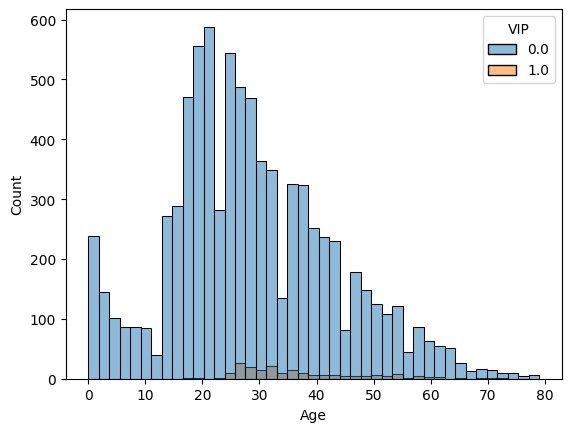

In [28]:
sns.histplot(data=df, x='Age', hue='VIP')

In [29]:
df['VIP'].value_counts()

VIP
0.0    8291
1.0     199
Name: count, dtype: int64

Мы видим, что распределение не является нормальным, а имеет правую скошенность, значит среднее значение > медианы => медианна предпочтительней, также посмотрим на vip: мы видим что доля не vip очень высокая => заполнять пропуски с помощью моделей бессмысленно при таком дисбалансе классов, самое логичное решение заполнить простой модой, а age заполним медианной по группе vip.

In [6]:
df['VIP'] = df['VIP'].fillna(0.0)

In [7]:
df['Age'] = df.groupby('VIP')['Age'].transform(lambda x: x.fillna(x.median()))

Проверим предположение, что  пассажиры из одиннаковых групп летят c/на одной и той же планеты.

In [8]:
df['№_of_group'], df['№_in_group'] = df['PassengerId'].apply(lambda x : x.split('_')[0]), df['PassengerId'].apply(lambda x : x.split('_')[1])

In [9]:
dest = df.groupby('№_of_group')['HomePlanet'].nunique()

print(f"Процент групп, где все люди с одной планеты: {(dest == 1).sum() / dest.shape[0] * 100}%")

Процент групп, где все люди с одной планеты: 98.23065787357245%


In [10]:
df['HomePlanet'] = df.groupby('№_of_group')['HomePlanet'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else df['HomePlanet'].mode()[0]))

df['Destination'] = df.groupby('№_of_group')['Destination'].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else df['Destination'].mode()[0]))

Сделаем вывод, что почти все группы формируются на одной планете, но не все группы летят в одно место, часть людей могла менять маршрут.

In [35]:
df.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           199
Destination       0
Age               0
VIP               0
RoomService     113
FoodCourt       113
ShoppingMall    112
Spa             118
VRDeck          126
Name            200
Transported       0
№_of_group        0
№_in_group        0
dtype: int64

Далее чтобы заполнить оставшиеся пропуски в колонках с тратами, посмотрим на распределение трат vip/no vip пассажиров

In [11]:
vip_spending = df.groupby("VIP")[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].mean()
print(vip_spending)


     RoomService    FoodCourt  ShoppingMall         Spa       VRDeck
VIP                                                                 
0.0   217.076446   423.162175    170.028973  298.189209   280.969179
1.0   473.615385  1802.056701    247.726804  756.868687  1228.556122


In [12]:
vip_spending = df.groupby("VIP")[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].max()
print(vip_spending)


     RoomService  FoodCourt  ShoppingMall      Spa   VRDeck
VIP                                                        
0.0      14327.0    27071.0       23492.0  22408.0  24133.0
1.0       8243.0    29813.0        3700.0  13902.0  12424.0


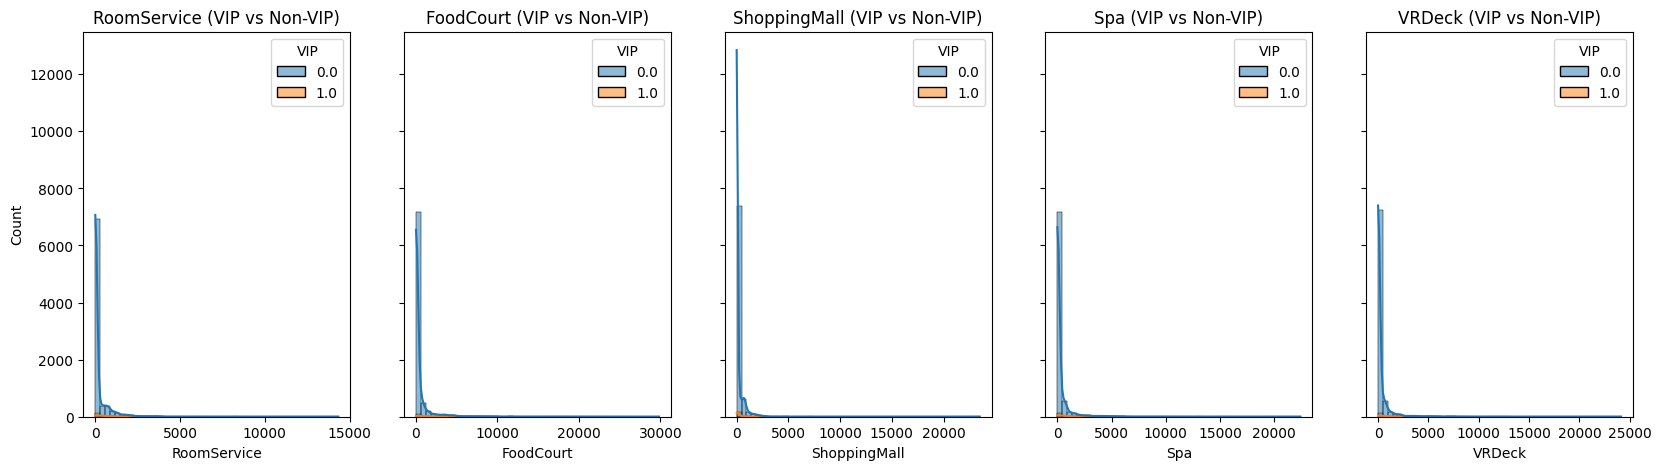

In [38]:
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)
cols = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

for i, col in enumerate(cols):
    sns.histplot(data=df, x=col, hue="VIP", bins=50, kde=True, ax=axes[i])
    axes[i].set_title(f"{col} (VIP vs Non-VIP)")

plt.show()


Итак мы видим, что траты как средние так и максимальные у vip персон логичные, а вот у no-vip есть выбросы, избавимся от них

In [13]:
vip_spending = df.groupby("VIP")[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].max().loc[1]

mask = (df["VIP"] == 0) & (
    (df["RoomService"] > vip_spending["RoomService"]) |
    (df["FoodCourt"] > vip_spending["FoodCourt"]) |
    (df["ShoppingMall"] > vip_spending["ShoppingMall"]) |
    (df["Spa"] > vip_spending["Spa"]) |
    (df["VRDeck"] > vip_spending["VRDeck"])
)

df = df[~mask]


In [40]:
df.shape

(8637, 16)

In [41]:
vip_spending = df.groupby("VIP")[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].max()
print(vip_spending)

     RoomService  FoodCourt  ShoppingMall      Spa   VRDeck
VIP                                                        
0.0       8209.0    27071.0        3700.0  13208.0  12392.0
1.0       8243.0    29813.0        3700.0  13902.0  12424.0


In [42]:
vip_spending = df.groupby("VIP")[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].mean()
print(vip_spending)

     RoomService    FoodCourt  ShoppingMall         Spa       VRDeck
VIP                                                                 
0.0   213.197335   412.607370    144.482655  277.200913   260.423572
1.0   473.615385  1802.056701    247.726804  756.868687  1228.556122


In [14]:
columns = ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

for col in columns:
    mean_vip = df.loc[df["VIP"] == 1, col].mean()
    median_non_vip = df.loc[df["VIP"] == 0, col].median()

    df.loc[(df["VIP"] == 1) & (df[col].isna()), col] = mean_vip
    df.loc[(df["VIP"] == 0) & (df[col].isna()), col] = median_non_vip

In [44]:
df.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep         0
Cabin           198
Destination       0
Age               0
VIP               0
RoomService       0
FoodCourt         0
ShoppingMall      0
Spa               0
VRDeck            0
Name            198
Transported       0
№_of_group        0
№_in_group        0
dtype: int64

Теперь разберемся с Cabin

In [15]:
df['Deck'] = df['Cabin'].str.split('/').str[0]
df['Num'] = df['Cabin'].str.split('/').str[1]
df['Side'] = df['Cabin'].str.split('/').str[2]

deck_consistency = df.groupby('№_of_group')['Deck'].nunique(dropna=True)
side_consistency = df.groupby('№_of_group')['Side'].nunique(dropna=True)

print(f"Процент групп с одинаковым Deck: {(deck_consistency == 1).sum() / deck_consistency.shape[0] * 100}%")
print(f"Процент групп с одинаковым Side: {(side_consistency == 1).sum() / side_consistency.shape[0] * 100}%")

Процент групп с одинаковым Deck: 91.58455822968826%
Процент групп с одинаковым Side: 98.38475205944113%


Отлично! Можем сделать вывод, что  надо заполнить пропуски в Deck и Side на основе группы.

In [16]:
df['Deck'] = df.groupby('№_of_group')['Deck'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else df['Deck'].mode()[0])
)
df['Side'] = df.groupby('№_of_group')['Side'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else df['Side'].mode()[0])
)

deck_side_nums = df.groupby(['Deck', 'Side'])['Num'].apply(lambda x: x.dropna().unique()).to_dict()
df['Num'] = df.apply(
    lambda row: row['Num'] if pd.notna(row['Num']) else np.random.choice(
        deck_side_nums.get((row['Deck'], row['Side']), ['0'])
    ),
    axis=1
)

df['Num'] = pd.to_numeric(df['Num'], errors='coerce')

Отлично, пропуски мы заполнили и от выбросов избавились, детальнее анализируем признаки.

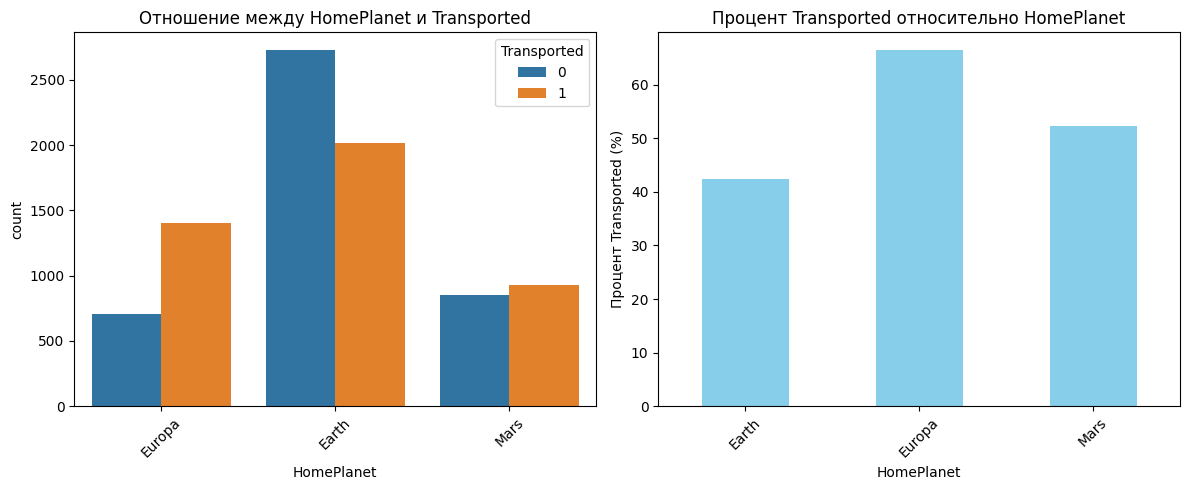

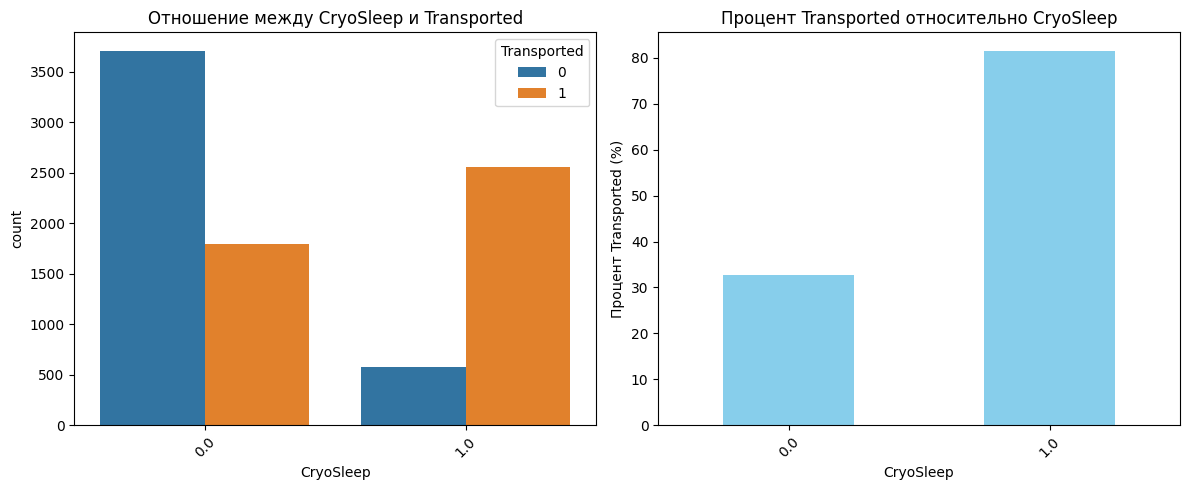

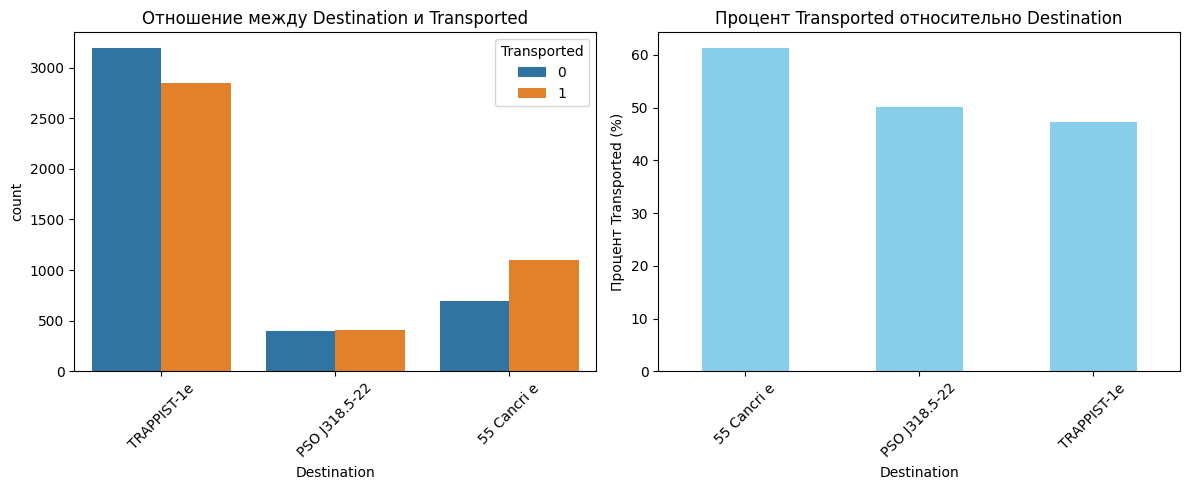

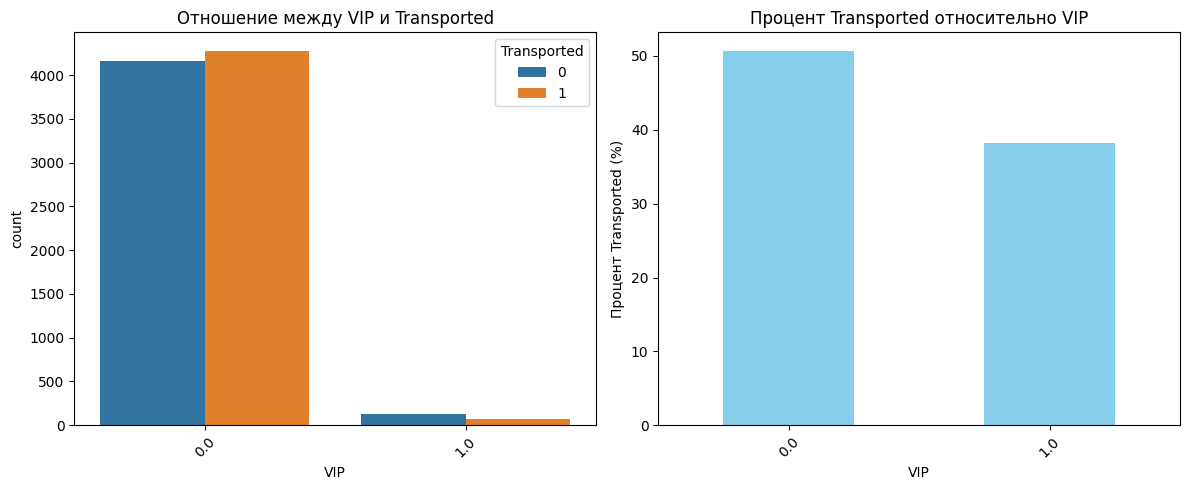

In [17]:
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

for feature in categorical_features:
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.countplot(x=feature, hue='Transported', data=df)
    plt.title(f'Отношение между {feature} и Transported')
    plt.xticks(rotation=45)

    plt.subplot(1, 2, 2)
    transport_rate = df.groupby(feature)['Transported'].mean() * 100
    transport_rate.plot(kind='bar', color='skyblue')
    plt.title(f'Процент Transported относительно {feature}')
    plt.ylabel('Процент Transported (%)')
    plt.xticks(rotation=45)

    plt.tight_layout()

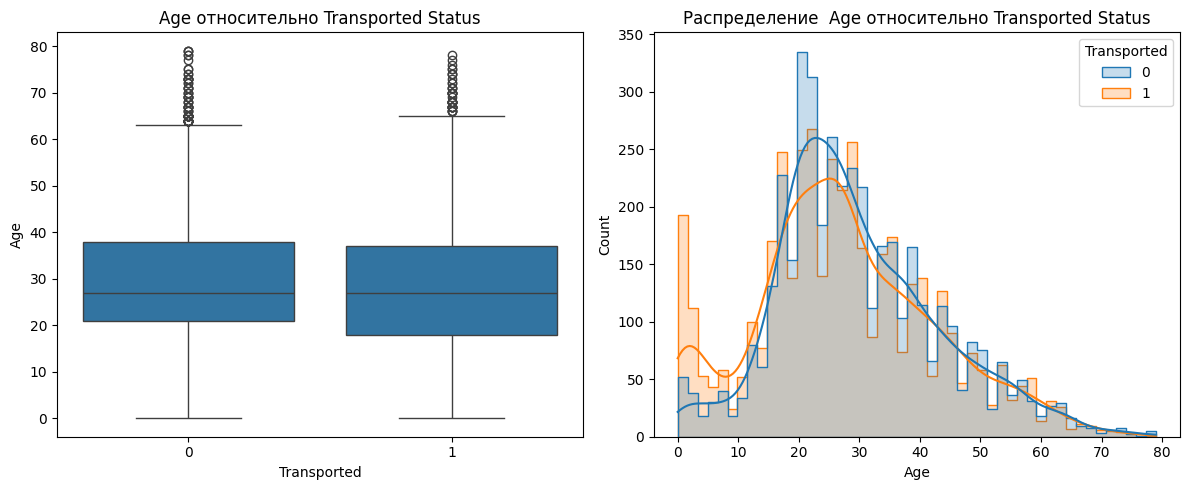

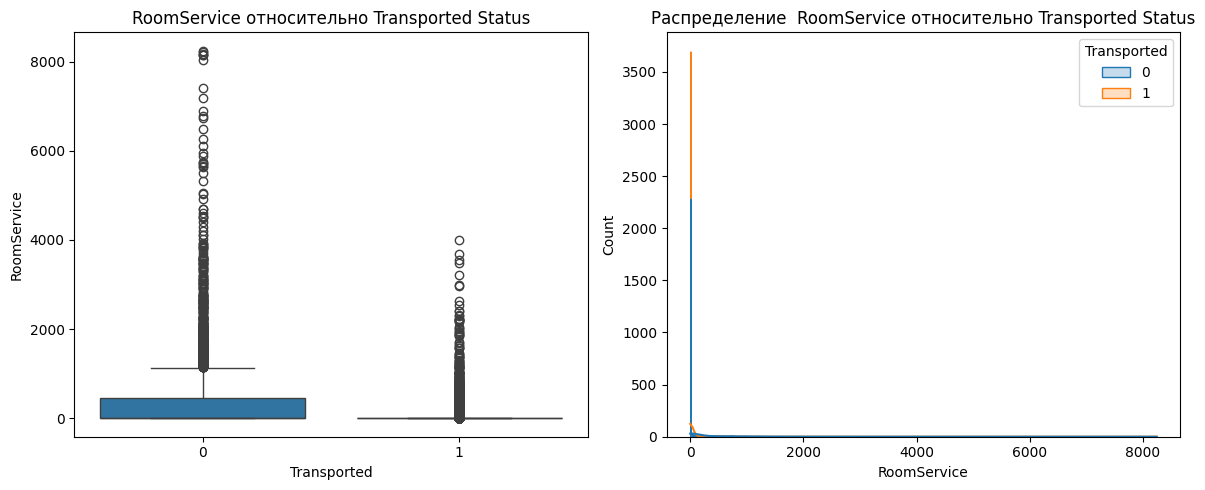

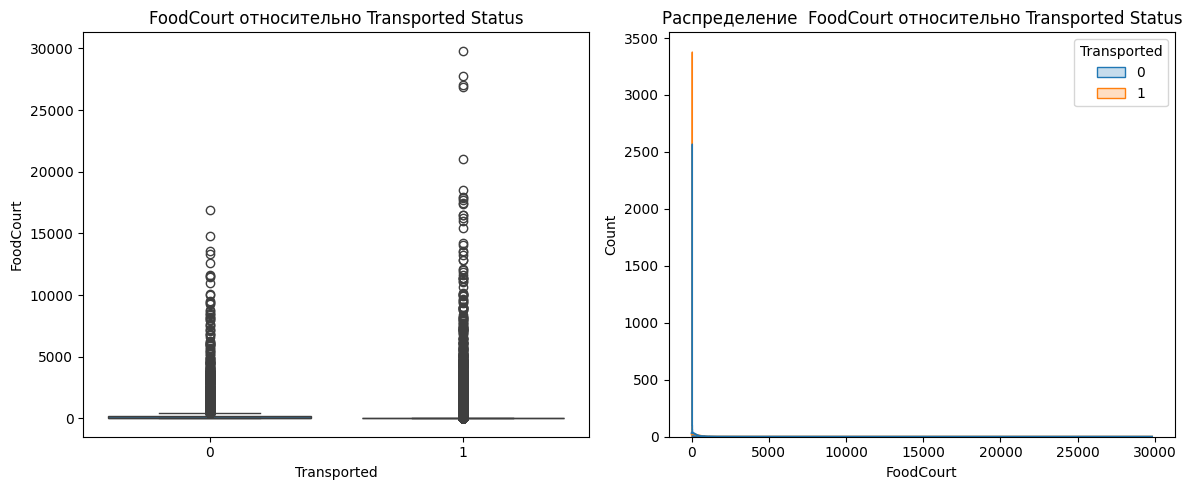

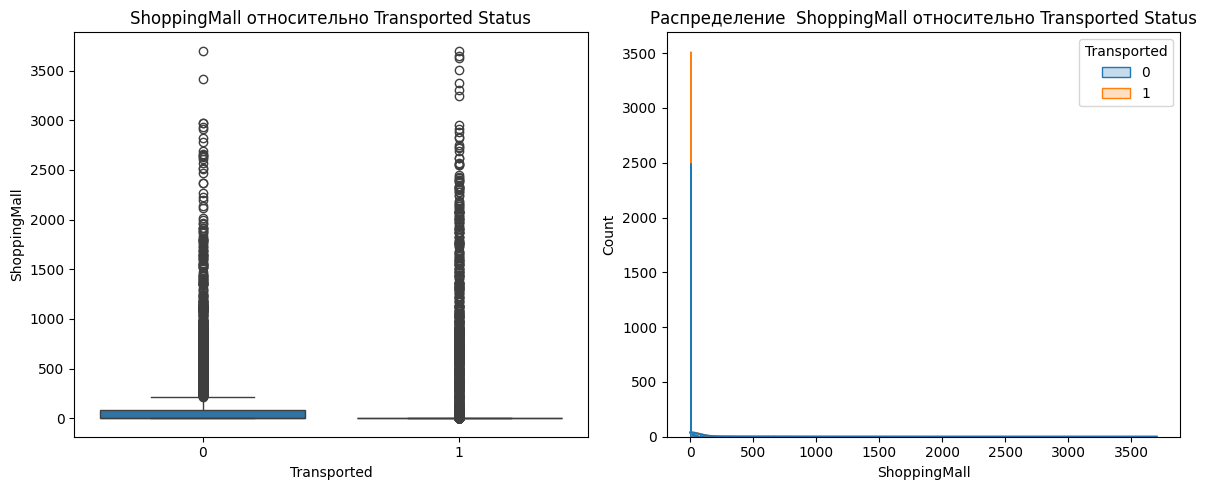

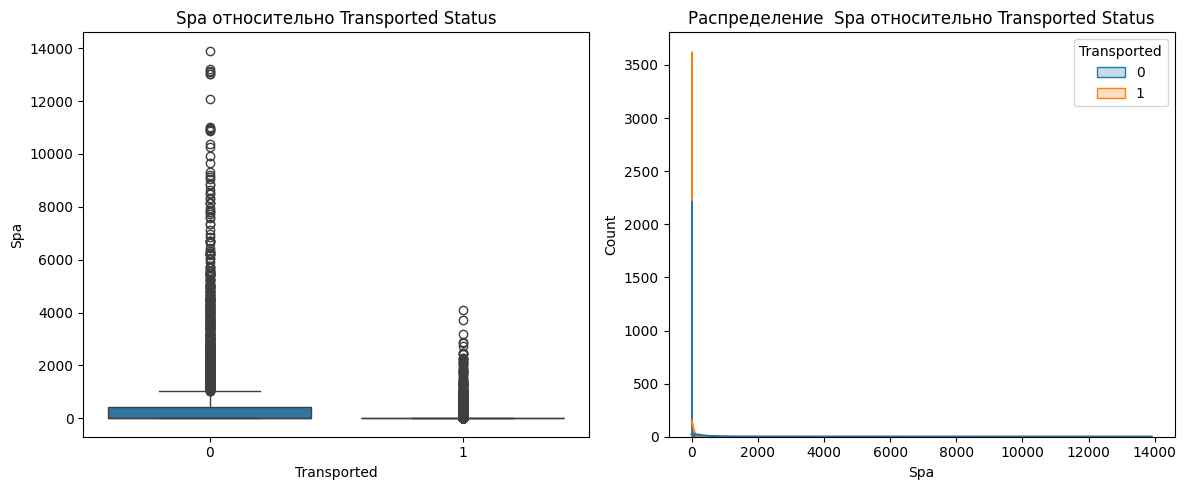

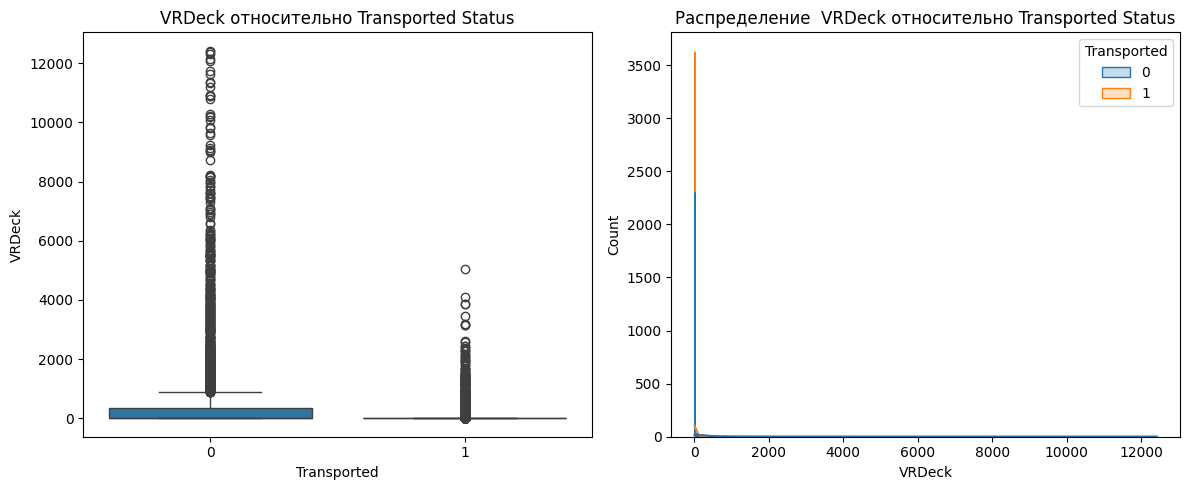

In [48]:

numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for feature in numerical_features:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(x='Transported', y=feature, data=df)
    plt.title(f'{feature} относительно Transported Status')

    plt.subplot(1, 2, 2)
    sns.histplot(data=df, x=feature, hue='Transported', element='step', kde=True, common_norm=False)
    plt.title(f'Распределение  {feature} относительно Transported Status')

    plt.tight_layout()

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'B'),
  Text(1, 0, 'F'),
  Text(2, 0, 'A'),
  Text(3, 0, 'G'),
  Text(4, 0, 'E'),
  Text(5, 0, 'D'),
  Text(6, 0, 'C'),
  Text(7, 0, 'T')])

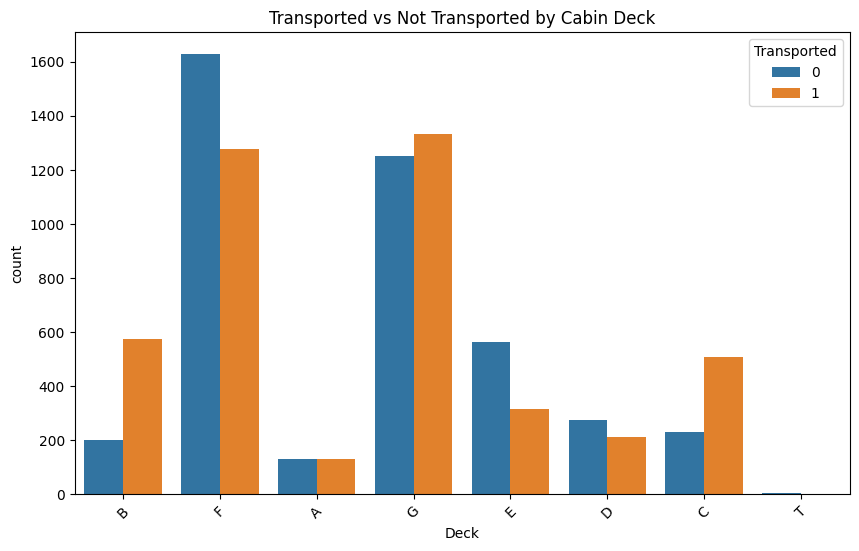

In [49]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Deck', hue='Transported', data=df)
plt.title('Transported vs Not Transported by Cabin Deck')
plt.xticks(rotation=45)

Text(0.5, 1.0, 'Correlation Matrix of Numerical Features')

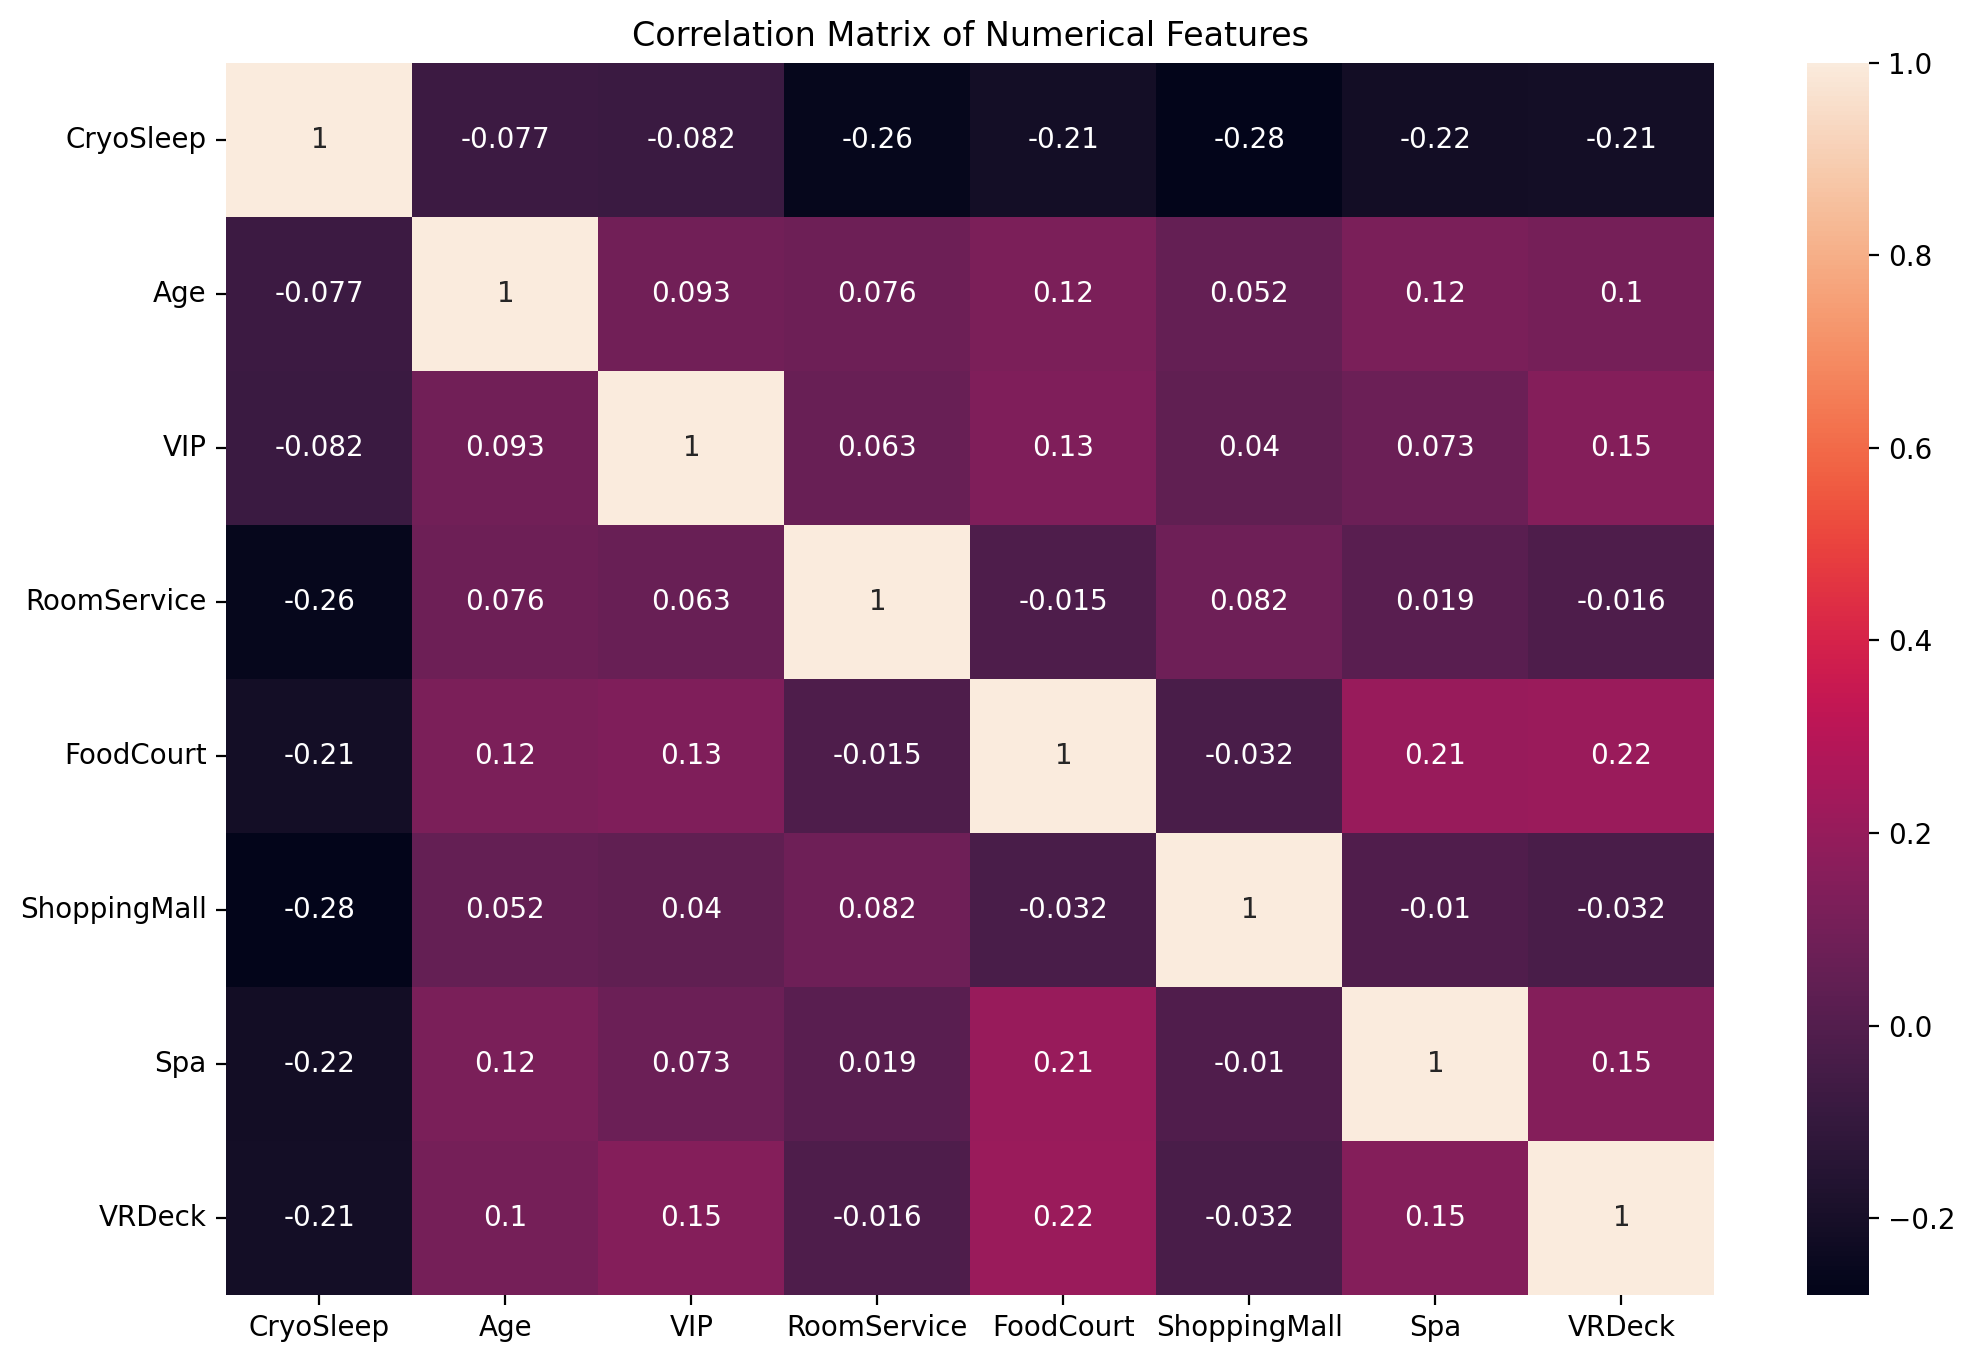

In [50]:
plt.figure(figsize=(12, 8), dpi=200)
correlation_matrix = df[df.select_dtypes(include=float).columns].corr()
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Matrix of Numerical Features')

Видим, что явной линейной зависимости между признаками нет, это замечательно.

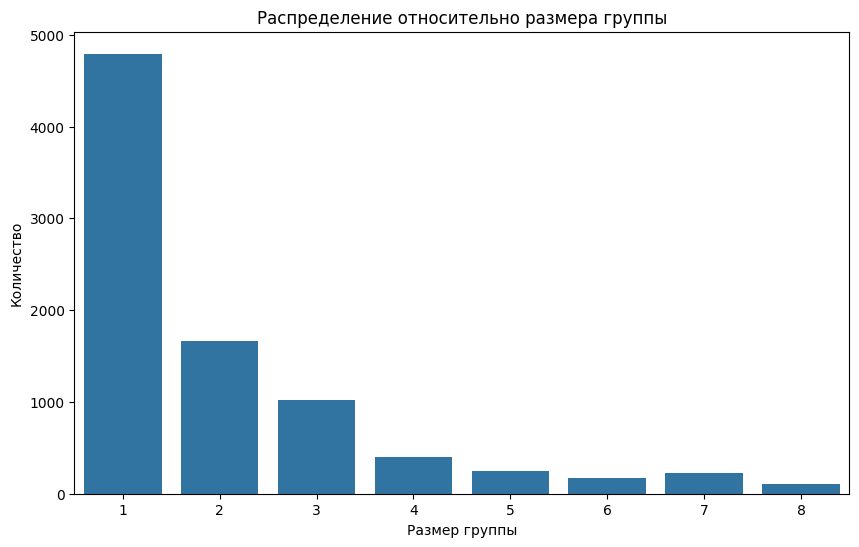

In [20]:
df['Group_Size'] = df.groupby('№_of_group')['№_in_group'].transform('count')

plt.figure(figsize=(10, 6))
sns.countplot(x='Group_Size', data=df, order=sorted(df['Group_Size'].unique()))
plt.title('Распределение относительно размера группы')
plt.xlabel('Размер группы')
plt.ylabel('Количество')
plt.show()

## Baseline

Теперь подготовим данные для обучения и сделаем baseline

Мы сделаем следующее:

1) Закодируем категориальные признаки с помощью TargetEncoder


В качестве baseline будем использовать дерево с параметрами по умолчанию

Удалим №_of_group, №_in_group так как они очевидно сильно коррелированы с размером группы

In [18]:
df = df.drop(['PassengerId', 'Cabin', '№_of_group', '№_in_group', 'Name'], axis=1)

In [19]:
X, y = df.drop('Transported', axis=1), df['Transported']

In [20]:
categorical_features = [col for col in X.columns if df[col].dtype == 'object' ]

numerical_features = [
    col for col in X.columns if col not in categorical_features]

numerical_features

['CryoSleep',
 'Age',
 'VIP',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Num']

In [21]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)

Поскольку работаем с решающем деревом, то масштабирование нам не нужно, поскольку на каждом разбиении и в каждом предикате оно работает только с одним из них 

In [23]:
enc = TargetEncoder(cols=categorical_features)

enc.fit(X_train, y_train)
X_train_new = enc.transform(X_train)
X_test_new = enc.transform(X_val)


In [24]:


model = DecisionTreeClassifier()
model.fit(X_train_new, y_train)
pred = model.predict(X_test_new)
predict_proba = model.predict_proba(X_test_new)[:, 1]

In [25]:
model

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [26]:
def print_metrics(predict, predict_proba, y_test):
    print({
        'accuracy' : accuracy_score(y_test, predict),
        'precision' : precision_score(y_test, predict),
        'recall' : recall_score(y_test, predict),
        'roc-auc' : roc_auc_score(y_test, predict_proba),
        'f1_score' : f1_score(y_test, predict)
    })

In [27]:
print_metrics(pred, predict_proba, y_val)

{'accuracy': 0.7490740740740741, 'precision': 0.757026291931097, 'recall': 0.7529305680793508, 'roc-auc': 0.7489676627266402, 'f1_score': 0.7549728752260397}


Зафиксируем baseline метрики.


Далее будем пытаться повысить roc-auc, на него можно опираться, поскольку он не зависит от порога перевода вероятностей в классы(это может нам помочь например для приоритетной эвакуации)

Также будем повышать f1
Поскольку нам нужен баланс между
 - Не отправлять лишних пассажиров в переполненные капсулы (Precision)
 - Не оставлять нуждающихся на корабле (Recall)

Теперь подберем гиперпараметры

In [28]:
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, None],
    'min_samples_split': [5, 10, 20, 30, 50, 100],
    'min_samples_leaf': [5, 10, 15, 20, 25, 30],
    'max_features': ['sqrt', 'log2', None, 0.5, 0.7],
    'min_impurity_decrease': [0.0, 0.001, 0.01, 0.05, 0.1],
    'ccp_alpha': np.linspace(0, 0.05, 10).tolist()  
}
grid_model = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_model.fit(X_train_new, y_train)

,estimator,DecisionTreeClassifier()
,param_grid,"{'ccp_alpha': [0.0, 0.005555555555555556, ...], 'max_depth': [3, 5, ...], 'max_features': ['sqrt', 'log2', ...], 'min_impurity_decrease': [0.0, 0.001, ...], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [29]:

pred = grid_model.predict(X_test_new)
predict_proba = grid_model.predict_proba(X_test_new)[:, 1]


In [30]:
print_metrics(pred, predict_proba, y_val)

{'accuracy': 0.7819444444444444, 'precision': 0.8343815513626834, 'recall': 0.7177637511271415, 'roc-auc': 0.8721248774193324, 'f1_score': 0.7716917111003393}


In [31]:
grid_model.best_estimator_

,criterion,'gini'
,splitter,'best'
,max_depth,10
,min_samples_split,100
,min_samples_leaf,30
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


ВЫВОДЫ ИЗ GRID SEARCH:

1) Вероятно, не переобучается (благодаря высоким min_samples)
2) Достаточно глубока для сложных зависимостей (depth=10)
3) неплоха  для интерпретации (не слишком большое дерево)

## Собственная Имплементация решающего дерева(классификатор)

In [32]:
import numpy as np
from collections import Counter
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import check_classification_targets
from scipy import stats

class MyDecisionTreeClassifier(BaseEstimator, ClassifierMixin):

    class Node:
        def __init__(self, feature_index=None, threshold=None, left=None, right=None,
                    value=None, impurity=None, n_samples=None, depth=0):
            self.feature_index = feature_index  
            self.threshold = threshold         
            self.left = left                    
            self.right = right                 
            self.value = value                 
            self.impurity = impurity            
            self.n_samples = n_samples          
            self.depth = depth                 
            
        def is_leaf(self):
            return self.value is not None
    
    def __init__(self, criterion='gini', max_depth=None, min_samples_split=2,
                 min_samples_leaf=1, min_impurity_decrease=0.0,
                 max_features=None, random_state=None, class_weight=None):
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_impurity_decrease = min_impurity_decrease
        self.max_features = max_features
        self.random_state = random_state
        self.class_weight = class_weight
        
        self.root = None
        self.n_classes_ = None
        self.n_features_in_ = None
        self.classes_ = None
        self.feature_importances_ = None
        self.tree_ = None
        
    def _check_params(self, n_features):
        """Проверка параметров."""
        if self.criterion not in ['gini', 'entropy']:
            raise ValueError(f"criterion must be 'gini' or 'entropy', got {self.criterion}")
            
        if self.max_depth is not None and self.max_depth <= 0:
            raise ValueError(f"max_depth must be > 0, got {self.max_depth}")
            
        if self.min_samples_split < 2:
            raise ValueError(f"min_samples_split must be >= 2, got {self.min_samples_split}")
            
        if self.min_samples_leaf < 1:
            raise ValueError(f"min_samples_leaf must be >= 1, got {self.min_samples_leaf}")
            
        if self.max_features is None:
            self._max_features = n_features
        elif isinstance(self.max_features, str):
            if self.max_features == 'sqrt':
                self._max_features = int(np.sqrt(n_features))
            elif self.max_features == 'log2':
                self._max_features = int(np.log2(n_features))
            else:
                raise ValueError(f"Unknown max_features string: {self.max_features}")
        elif isinstance(self.max_features, int):
            self._max_features = min(self.max_features, n_features)
        elif isinstance(self.max_features, float):
            self._max_features = max(1, int(self.max_features * n_features))
        else:
            raise ValueError(f"Invalid max_features: {self.max_features}")
            
        if self.random_state is not None:
            np.random.seed(self.random_state)
            
    def _compute_impurity(self, y):
        n_samples = len(y)
        if n_samples == 0:
            return 0
            
        if self.class_weight is not None:
            if self.class_weight == 'balanced':
                class_weights = {}
                total = len(y)
                for cls in self.classes_:
                    class_weights[cls] = total / (len(self.classes_) * np.sum(y == cls))
            else:
                class_weights = self.class_weight
        else:
            class_weights = {cls: 1.0 for cls in self.classes_}
        
        weighted_counts = {}
        for cls in self.classes_:
            cls_mask = (y == cls)
            weighted_counts[cls] = np.sum(cls_mask) * class_weights.get(cls, 1.0)
        
        total_weighted = sum(weighted_counts.values())
        if total_weighted == 0:
            return 0
            
        if self.criterion == 'gini':
            gini = 1.0
            for count in weighted_counts.values():
                prob = count / total_weighted
                gini -= prob ** 2
            return gini
            
        elif self.criterion == 'entropy':
            entropy = 0.0
            for count in weighted_counts.values():
                prob = count / total_weighted
                if prob > 0:
                    entropy -= prob * np.log2(prob)
            return entropy
            
    def _best_split(self, X, y):
        n_samples, n_features = X.shape
        
        if n_samples < self.min_samples_split:
            return None, None
            
        current_impurity = self._compute_impurity(y)
        if current_impurity == 0:
            return None, None
            
        best_gain = 0.0
        best_feature = None
        best_threshold = None
        
        if self._max_features < n_features:
            features = np.random.choice(n_features, self._max_features, replace=False)
        else:
            features = range(n_features)
        
        for feature_index in features:
            feature_values = X[:, feature_index]
            unique_values = np.unique(feature_values)
            
            for i in range(len(unique_values) - 1):
                threshold = (unique_values[i] + unique_values[i + 1]) / 2
                
                left_mask = feature_values <= threshold
                right_mask = ~left_mask
                
                if (np.sum(left_mask) < self.min_samples_leaf or 
                    np.sum(right_mask) < self.min_samples_leaf):
                    continue
                
                y_left = y[left_mask]
                y_right = y[right_mask]
                
                impurity_left = self._compute_impurity(y_left)
                impurity_right = self._compute_impurity(y_right)
                
                n_left = len(y_left)
                n_right = len(y_right)
                
                weighted_impurity = (n_left * impurity_left + n_right * impurity_right) / n_samples
                
                gain = current_impurity - weighted_impurity
                
                if gain > best_gain and gain >= self.min_impurity_decrease:
                    best_gain = gain
                    best_feature = feature_index
                    best_threshold = threshold
        
        return best_feature, best_threshold
    
    def _grow_tree(self, X, y, depth=0):
        n_samples = X.shape[0]
        
        if len(np.unique(y)) == 1:
            value = stats.mode(y, keepdims=True)[0][0]
            return self.Node(
                value=value,
                impurity=self._compute_impurity(y),
                n_samples=n_samples,
                depth=depth
            )
            
        if (self.max_depth is not None and depth >= self.max_depth) or \
           (n_samples < self.min_samples_split):
            value = stats.mode(y, keepdims=True)[0][0]
            return self.Node(
                value=value,
                impurity=self._compute_impurity(y),
                n_samples=n_samples,
                depth=depth
            )
        
        best_feature, best_threshold = self._best_split(X, y)
        
        if best_feature is None:
            value = stats.mode(y, keepdims=True)[0][0]
            return self.Node(
                value=value,
                impurity=self._compute_impurity(y),
                n_samples=n_samples,
                depth=depth
            )
        
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        
        left_subtree = self._grow_tree(X[left_mask], y[left_mask], depth + 1)
        right_subtree = self._grow_tree(X[right_mask], y[right_mask], depth + 1)
        
        return self.Node(
            feature_index=best_feature,
            threshold=best_threshold,
            left=left_subtree,
            right=right_subtree,
            impurity=self._compute_impurity(y),
            n_samples=n_samples,
            depth=depth
        )
    
    def _compute_feature_importances(self, node):
        if node.is_leaf():
            return
            
        gain = node.impurity - (
            (node.left.n_samples / node.n_samples) * node.left.impurity +
            (node.right.n_samples / node.n_samples) * node.right.impurity
        )
        
        self.feature_importances_[node.feature_index] += gain * node.n_samples
        
        self._compute_feature_importances(node.left)
        self._compute_feature_importances(node.right)
    
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        check_classification_targets(y)
        
        self.n_features_in_ = X.shape[1]
        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)
        
        self._check_params(self.n_features_in_)
        
        self.feature_importances_ = np.zeros(self.n_features_in_)
        
        self.root = self._grow_tree(X, y)
        
        self._compute_feature_importances(self.root)
        
        if self.feature_importances_.sum() > 0:
            self.feature_importances_ /= self.feature_importances_.sum()
        
        self.tree_ = self._build_sklearn_tree(self.root)
        
        return self
    
    def _build_sklearn_tree(self, node):
        if node.is_leaf():
            return {
                'value': np.array([node.value]),
                'impurity': node.impurity,
                'n_node_samples': node.n_samples,
                'depth': node.depth
            }
        
        tree = {
            'feature': node.feature_index,
            'threshold': node.threshold,
            'impurity': node.impurity,
            'n_node_samples': node.n_samples,
            'depth': node.depth,
            'left': self._build_sklearn_tree(node.left),
            'right': self._build_sklearn_tree(node.right)
        }
        
        return tree
    
    def _predict_sample(self, x, node):
        if node.is_leaf():
            return node.value
        
        if x[node.feature_index] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)
    
    def predict(self, X):
        check_is_fitted(self, 'root')
        X = check_array(X)
        
        predictions = []
        for x in X:
            pred = self._predict_sample(x, self.root)
            predictions.append(pred)
            
        return np.array(predictions)
    
    def predict_proba(self, X):
        check_is_fitted(self, 'root')
        X = check_array(X)
        predictions = self.predict(X)
        proba = np.zeros((len(X), self.n_classes_))
        
        for i, pred in enumerate(predictions):
            class_idx = np.where(self.classes_ == pred)[0][0]
            proba[i, class_idx] = 1.0
            
        return proba
    
    def predict_log_proba(self, X):
        proba = self.predict_proba(X)
        return np.log(proba + 1e-15)
    
    def score(self, X, y):
        from sklearn.metrics import accuracy_score
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)
    
    def get_depth(self):
        check_is_fitted(self, 'root')
        return self._get_node_depth(self.root)
    
    def _get_node_depth(self, node):
        if node.is_leaf():
            return node.depth
        return max(self._get_node_depth(node.left), self._get_node_depth(node.right))
    
    def get_n_leaves(self):
        check_is_fitted(self, 'root')
        return self._count_leaves(self.root)
    
    def _count_leaves(self, node):
        if node.is_leaf():
            return 1
        return self._count_leaves(node.left) + self._count_leaves(node.right)
    
    def get_params(self, deep=True):
        return {
            'criterion': self.criterion,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'min_samples_leaf': self.min_samples_leaf,
            'min_impurity_decrease': self.min_impurity_decrease,
            'max_features': self.max_features,
            'random_state': self.random_state,
            'class_weight': self.class_weight
        }
    
    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self
    
    def apply(self, X):
        check_is_fitted(self, 'root')
        X = check_array(X)
        
        indices = []
        for x in X:
            leaf_id = self._apply_sample(x, self.root)
            indices.append(leaf_id)
            
        return np.array(indices)
    
    def _apply_sample(self, x, node, leaf_id=0):
        if node.is_leaf():
            return leaf_id
        
        if x[node.feature_index] <= node.threshold:
            return self._apply_sample(x, node.left, leaf_id * 2 + 1)
        else:
            return self._apply_sample(x, node.right, leaf_id * 2 + 2)
    
    def decision_path(self, X):
        from scipy.sparse import csr_matrix
        check_is_fitted(self, 'root')
        X = check_array(X)
        
        paths = []
        for x in X:
            path = self._decision_path_sample(x, self.root)
            paths.append(path)
        
        n_samples = len(X)
        n_nodes = self._count_nodes(self.root)
        
        data = []
        rows = []
        cols = []
        
        for i, path in enumerate(paths):
            for node_id in path:
                data.append(1)
                rows.append(i)
                cols.append(node_id)
        
        return csr_matrix((data, (rows, cols)), shape=(n_samples, n_nodes))
    
    def _decision_path_sample(self, x, node, node_id=0, path=None):
        if path is None:
            path = []
        
        path.append(node_id)
        
        if node.is_leaf():
            return path
        
        if x[node.feature_index] <= node.threshold:
            return self._decision_path_sample(x, node.left, node_id * 2 + 1, path)
        else:
            return self._decision_path_sample(x, node.right, node_id * 2 + 2, path)
    
    def _count_nodes(self, node):
        if node.is_leaf():
            return 1
        return 1 + self._count_nodes(node.left) + self._count_nodes(node.right)

В качестве baseline возьмем :
параметры  как в базовой реализации из sklearn 

In [36]:

my_tree = MyDecisionTreeClassifier()

my_tree.fit(X_train_new, y_train)

y_pred_my = my_tree.predict(X_test_new)
y_pred_proba_my = my_tree.predict_proba(X_test_new)



Чтобы пофиксить проблемы с рамерностями для roc-auc немного перепишем функцию для подсчета метрик 

In [39]:

def print_metrics(predict, predict_proba, y_test):

    if predict_proba.ndim == 2:
        y_proba = predict_proba[:, 1]
    else:
        y_proba = predict_proba
    
    print({
        'accuracy': accuracy_score(y_test, predict),
        'precision': precision_score(y_test, predict),
        'recall': recall_score(y_test, predict),
        'roc-auc': roc_auc_score(y_test, y_proba),  
        'f1_score': f1_score(y_test, predict)
    })

In [40]:
print_metrics(y_pred_my, y_pred_proba_my, y_val)

{'accuracy': 0.7421296296296296, 'precision': 0.7495479204339964, 'recall': 0.7475202885482417, 'roc-auc': 0.7419808864244538, 'f1_score': 0.7485327313769752}


Видим что метрики практически идентичны с базовой реализацией из sklearn 

Теперь обучим с лучшими параметрами 

In [42]:
my_tree = MyDecisionTreeClassifier(
    criterion='gini',
    max_depth=10,
    min_samples_split=100,
    min_samples_leaf=30,
    min_impurity_decrease=0.0,
    max_features=None, 
    random_state=None,
    class_weight=None
)

my_tree.fit(X_train_new, y_train)

y_pred_my = my_tree.predict(X_test_new)
y_pred_proba_my = my_tree.predict_proba(X_test_new)


In [44]:
print_metrics(y_pred_my, y_pred_proba_my, y_val)

{'accuracy': 0.7819444444444444, 'precision': 0.8343815513626834, 'recall': 0.7177637511271415, 'roc-auc': 0.7837153674760351, 'f1_score': 0.7716917111003393}


Видим что удалось добиться почти таких же метрик как и на реализации из sklearn

# Решающее дерево(регрессор)

Будем предсказывать цену машины по ее характеристикам 

In [7]:
data = pd.read_csv('train.csv')

In [87]:
data.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate,sellingprice
0,2013,Dodge,Dart,Limited,Sedan,automatic,1c3cdfca5dd293552,mo,4.6,13957.0,gray,black,chrysler capital,Wed Jan 21 2015 02:30:00 GMT-0800 (PST),14500
1,2014,Honda,Civic,LX,Sedan,automatic,19xfb2f56ee228781,ca,5.0,2401.0,gray,black,"ahfc/honda lease trust/hvt, inc.",Thu Feb 26 2015 04:00:00 GMT-0800 (PST),16500
2,2012,Chevrolet,Traverse,LT,suv,automatic,1gnkrged3cj244704,wi,2.4,70046.0,white,black,capital one auto finance,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT),13700
3,2014,Nissan,Versa Note,1.6 SV,Hatchback,automatic,3n1ce2cp9el407766,fl,2.6,23415.0,gray,black,florida auto financial group,Tue Feb 17 2015 01:30:00 GMT-0800 (PST),9800
4,2014,Nissan,Versa,1.6 SV,sedan,automatic,3n1cn7ap4el813308,il,3.4,17040.0,blue,black,nissan motor acceptance corporation,Thu Jun 04 2015 03:00:00 GMT-0700 (PDT),10300


In [88]:
data.describe()

,year,condition,odometer,sellingprice
count,396212.000000,387759.000000,396151.000000,396212.000000
mean,2010.041442,3.425687,68336.479029,13593.389859
std,3.977384,0.949871,53559.280598,9754.143816
min,1982.000000,1.000000,1.000000,1.000000
25%,2007.000000,2.700000,28259.000000,6900.000000
50%,2012.000000,3.600000,52113.000000,12100.000000
75%,2013.000000,4.200000,99300.000000,18200.000000
max,2015.000000,5.000000,999999.000000,230000.000000


In [8]:
X = data.drop('sellingprice', axis=1)
y = data['sellingprice']

## EDA

Посмтрим на категориальные признаки

In [90]:
X.describe(include='object')


,make,model,trim,body,transmission,vin,state,color,interior,seller,saledate
count,388993,388922,388727,386883,350025,396212,396212,395679,395679,396212,396212
unique,91,949,1899,83,2,396212,38,20,17,12530,3544
top,Ford,Altima,Base,Sedan,automatic,1c3cdfca5dd293552,fl,black,black,nissan-infiniti lt,Tue Feb 10 2015 01:30:00 GMT-0800 (PST)
freq,66391,13969,39538,141921,337646,1,59164,78576,173230,14323,3783


Признак vin это уникальный идентификатор машины, поэтому удалим его.


In [9]:

X.drop('vin', axis=1, inplace=True)

Заполним пропуски в числовых столбцах средним значением, а в категориальных - пустой категорией



In [10]:
for c in X.columns:
    if X[c].dtype == 'object':
          X[c].fillna("", inplace=True)
for c in X.columns:
    if X[c].dtype != 'object':
          mean = np.mean(X[c])
          X[c].fillna(mean, inplace=True)

/var/folders/sy/bq09pg_j1599sryhztwt0p880000gn/T/ipykernel_11341/122545764.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[c].fillna("", inplace=True)
/var/folders/sy/bq09pg_j1599sryhztwt0p880000gn/T/ipykernel_11341/122545764.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Посмотрим на количество значений в каждой категории



In [101]:
for c in X.columns:
    if X[c].dtype == 'object':
          print(c, len(X[c].unique()))

make 92
model 950
trim 1900
body 84
transmission 3
state 38
color 21
interior 18
seller 12530
saledate 3544


В saledate очень много различных значений. Посмотрим почему.



In [88]:
X[['year','saledate']]


,year,saledate
0,2013,Wed Jan 21 2015 02:30:00 GMT-0800 (PST)
1,2014,Thu Feb 26 2015 04:00:00 GMT-0800 (PST)
2,2012,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
3,2014,Tue Feb 17 2015 01:30:00 GMT-0800 (PST)
4,2014,Thu Jun 04 2015 03:00:00 GMT-0700 (PDT)
...,...,...
396207,2013,Wed Jun 17 2015 03:00:00 GMT-0700 (PDT)
396208,2009,Mon Jun 08 2015 02:00:00 GMT-0700 (PDT)
396209,2004,Tue Jan 20 2015 02:30:00 GMT-0800 (PST)
396210,2013,Fri Dec 19 2014 11:45:00 GMT-0800 (PST)


Обработаем saledate:

сделаем признак car_age - возраст машины в годах
сделаем признак date - месяц+год продажи машины (категориальный)
Исходный признак saledate удалим

In [11]:
X['car_age'] = X['saledate'].apply(lambda x: int(x.split(" ")[3])) - X['year']
X['date'] = X['saledate'].apply(lambda x: x.split(" ")[1]+x.split(" ")[3])

X.drop('saledate', axis=1, inplace=True)


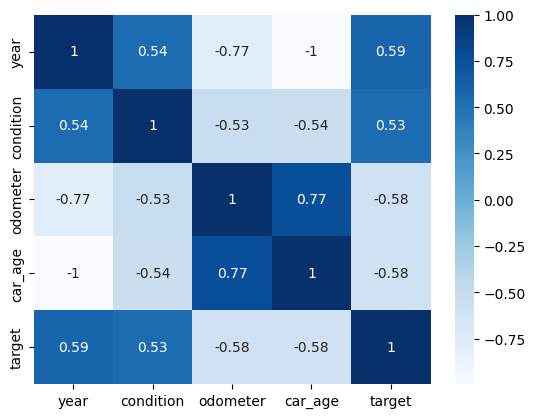

In [12]:
import seaborn as sb

X['target'] = y

cols = X.columns[X.dtypes != 'object']

corr = X[cols].corr()
sb.heatmap(corr, cmap="Blues", annot=True)

X.drop('target', axis=1, inplace=True)

Посмотрим на аналог корреляции категориальных признаков

In [97]:
!pip install association-metrics


  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'association-metrics' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'association-metrics'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for association-metrics: filename=association_metrics-0.0.1-py3-none-any.whl size=3978 sha256=6c0c0ab393dbb3b40dd3591d75a9815e4d2918df927abef9525afb35fc7ed805
  Stored in directory: /Users/fltww/Library/Caches/pip/wheels/01/47/5f/4360ef6988df6f1b0c1857cab43334269110160bd97b716936
Successfully built association-metrics


In [13]:
import association_metrics as am

XC = X.apply(
        lambda x: x.astype("category") if x.dtype == "object" else x)

cramersv = am.CramersV(XC)

cramersv.fit()

/opt/anaconda3/envs/ml/lib/python3.10/site-packages/association_metrics/categorical.py:100: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  self.matrix[x][y] = 1
/opt/anaconda3/envs/ml/lib/python3.10/site-packages/association_metrics/categoric

,make,model,trim,body,transmission,state,color,interior,seller,date
make,1.000000,0.942073,0.768825,0.189035,0.161258,0.080016,0.085875,0.108237,0.405386,0.059136
model,0.942073,1.000000,0.552843,0.615147,0.310298,0.120689,0.145266,0.181734,0.287182,0.086036
trim,0.768825,0.552843,1.000000,0.437450,0.291284,0.131441,0.139243,0.210486,0.267798,0.099165
body,0.189035,0.615147,0.437450,1.000000,0.171188,0.054380,0.070882,0.073898,0.251710,0.298083
transmission,0.161258,0.310298,0.291284,0.171188,1.000000,0.377115,0.063472,0.066053,0.394181,0.031898
state,0.080016,0.120689,0.131441,0.054380,0.377115,1.000000,0.064536,0.062192,0.679166,0.081021
color,0.085875,0.145266,0.139243,0.070882,0.063472,0.064536,1.000000,0.259053,0.233966,0.018536
interior,0.108237,0.181734,0.210486,0.073898,0.066053,0.062192,0.259053,1.000000,0.258849,0.061795
seller,0.405386,0.287182,0.267798,0.251710,0.394181,0.679166,0.233966,0.258849,1.000000,0.286704
date,0.059136,0.086036,0.099165,0.298083,0.031898,0.081021,0.018536,0.061795,0.286704,1.000000


In [14]:
X.drop('make', axis=1, inplace=True)


Признаки make и model сильно связаны, поэтому уберем make как менее информативный



Посмотрим влияние на целевуб переменную 



<Axes: xlabel='None', ylabel='sellingprice'>

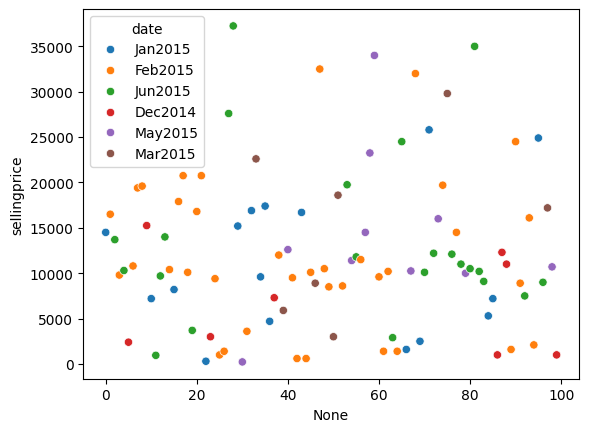

In [100]:
import seaborn as sns

sns.scatterplot(data=X.iloc[:100], x=X.iloc[:100].index, y=y[:100], hue='date')

<Axes: xlabel='None', ylabel='sellingprice'>

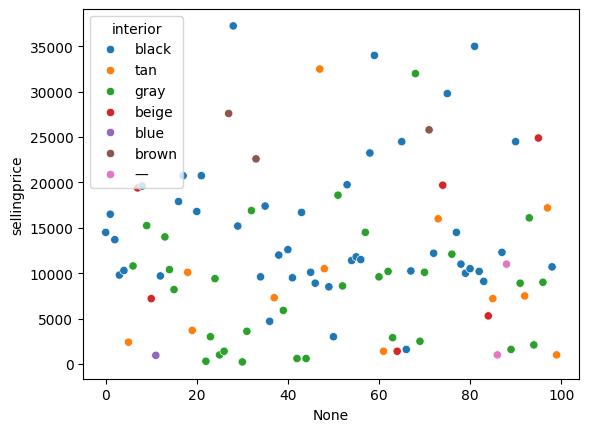

In [101]:
sns.scatterplot(data=X.iloc[:100], x=X.iloc[:100].index, y=y[:100], hue='interior')


<Axes: xlabel='None', ylabel='sellingprice'>

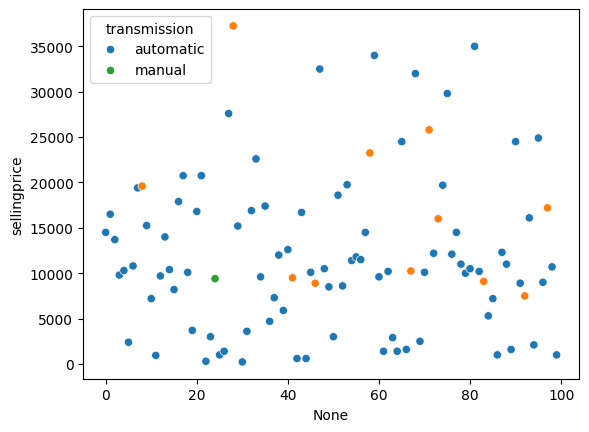

In [102]:
sns.scatterplot(data=X.iloc[:100], x=X.iloc[:100].index, y=y[:100], hue='transmission')


Посмотрим на распределение целевой переменной



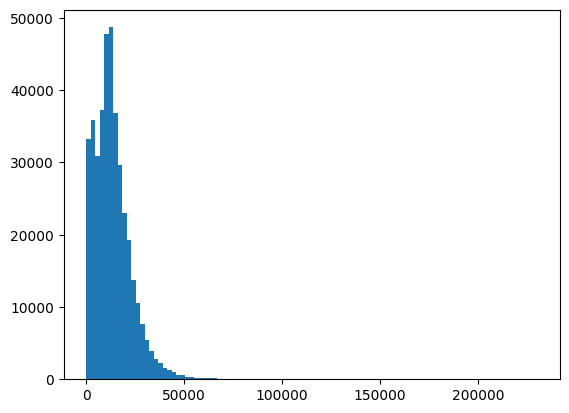

In [103]:
plt.hist(y, bins=100);


Видим что распределение не является нормальным, но пока ничего с ним делать не будем 

Поищем выбросы

In [15]:
cat_cols = X.columns[X.dtypes == 'object']
num_cols = X.columns[X.dtypes != 'object']

year


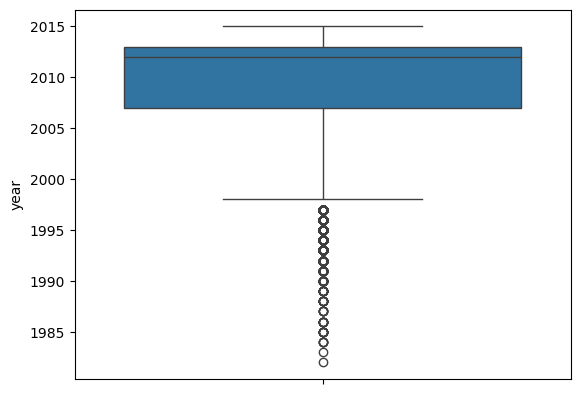

condition


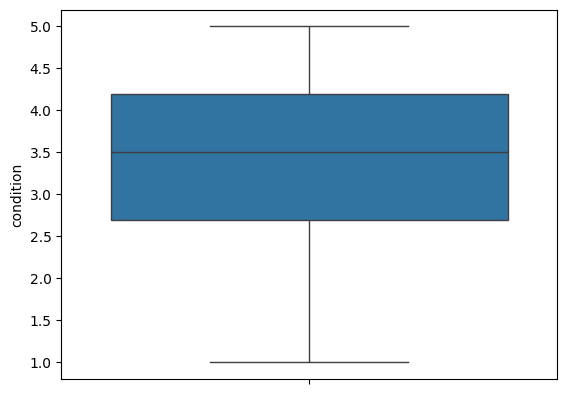

odometer


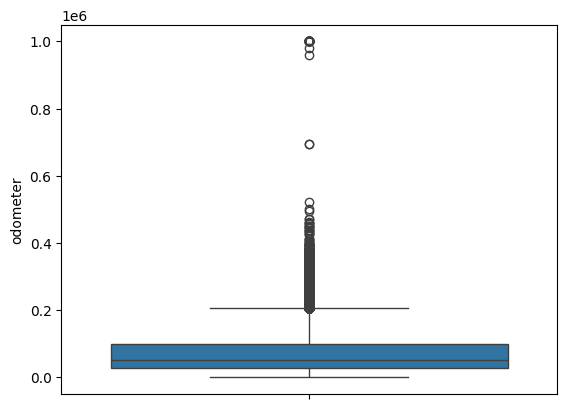

car_age


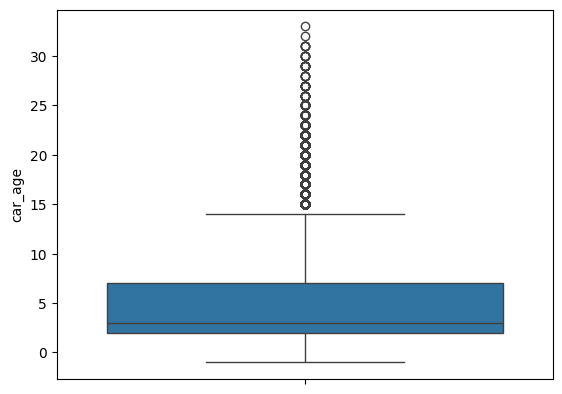

In [105]:
for col in num_cols:
    print(col)
    sb.boxplot(X[col])
    plt.show()

In [106]:
X[X['odometer'] > 800000][['car_age','odometer']]


,car_age,odometer
8651,8,999999.0
26775,8,999999.0
39643,8,999999.0
59125,8,999999.0
69969,9,999999.0
70028,10,999999.0
78649,9,999999.0
90539,14,999999.0
94884,2,999999.0
105833,8,999999.0


Выкинем машины младше 10 лет, проехавшие 1_000_000 миль - это почти точно выбросы.



In [16]:
Xnew = X[~((X.car_age < 10) & (X.odometer > 800_000))]
ynew = y[~((X.car_age < 10) & (X.odometer > 800_000))]

Xnew.drop('car_age', axis=1, inplace=True)

/var/folders/sy/bq09pg_j1599sryhztwt0p880000gn/T/ipykernel_11341/4066289098.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xnew.drop('car_age', axis=1, inplace=True)


### BASELINE

Для baseline-модели мы сделаем следующее:

закодируем категориальные признаки при помощи TargetEncoder

обучим решающее дерево

In [17]:
from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(Xnew, ynew, test_size=0.25, random_state=42)

In [57]:

enc = TargetEncoder(cols=cat_cols)

enc.fit(X_train, y_train)
X_train_new = enc.transform(X_train)
X_test_new = enc.transform(X_test)

model = DecisionTreeRegressor()
model.fit(X_train_new, y_train)
pred = model.predict(X_test_new)

В качестве метрик будем использовать комбинацию r2 + mae + mape 

Поскольку : 

R² - обьясняет насколько мы лучше чем банальное среднее 

MAE - смотрим общую картину

MAPE - оценим стабильность на дорогих и дешевых авто 

In [28]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

In [26]:
def print_metrics(y_true, y_pred , return_dict=False):
  
    def safe_mape(true, pred):
        true = np.where(true == 0, 1e-10, true)
        return np.mean(np.abs((true - pred) / true)) * 100
    
    def safe_mdape(true, pred):
        true = np.where(true == 0, 1e-10, true)
        return np.median(np.abs((true - pred) / true)) * 100
    
    metrics = {
        'R²': r2_score(y_true, y_pred),
        'MAE': mean_absolute_error(y_true, y_pred),
        'MAPE': safe_mape(y_true, y_pred),
        'MdAPE': safe_mdape(y_true, y_pred),  
        'Max Error': np.max(np.abs(y_true - y_pred))
    }
    
    residuals = y_true - y_pred
    metrics.update({
        'Mean Residual': np.mean(residuals),
        'Std Residual': np.std(residuals)
    })
    
 
    
    for metric, value in metrics.items():
        if metric in ['R²']:
            print(f"{metric:>12}: {value:>8.4f}")
        elif metric in ['MAPE', 'MdAPE']:
            print(f"{metric:>12}: {value:>7.2f}%")
        elif metric in ['MAE', 'RMSE', 'Max Error', 'Mean Residual', 'Std Residual']:
            print(f"{metric:>12}: {value:>8.2f}")
        elif metric == 'MSE':
            print(f"{metric:>12}: {value:>8.2e}")
    
    if return_dict:
        return metrics

In [60]:
print_metrics(y_test, pred)

          R²:   0.8857
         MAE:  1832.78
        MAPE:   27.02%
       MdAPE:   10.20%
   Max Error: 200500.00
Mean Residual:   -10.79
Std Residual:  3298.09


 Сильные стороны: Высокий R², хорошая медианная точность (10%)

 Проблемы: Большая максимальная ошибка, высокий средний процент ошибки (27%)

 
 Очевидно что проблема при предиктах на очень дорогих авто, потенциально ансамбли в будущих лабах помогут решить эту проблему 

при этом простое дерево уже объясняет почти 90% вариативности цен, что является отличным результатом 

Теперь попробуем подобрать кодировщик а затем проведем подбор гиперпараметров 

In [62]:
from sklearn.pipeline import Pipeline

p0 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=1)),
    ('model_', DecisionTreeRegressor())
    ])

p1 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=100)),
    ('model_', DecisionTreeRegressor())
    ])

p2 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=1)),
    ('model_', DecisionTreeRegressor())
    ])

p3 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=10)),
    ('model_', DecisionTreeRegressor())
    ])

p4 = Pipeline([
    ('encoder_',TargetEncoder(cols=cat_cols, smoothing=100)),
    ('model_', DecisionTreeRegressor())
    ])

p5 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=cat_cols)),
    ('model_', DecisionTreeRegressor())
    ])

p6 = Pipeline([
    ('encoder_',LeaveOneOutEncoder(cols=cat_cols)),
    ('model_', DecisionTreeRegressor())
    ])

Выберем по лучшему mape 

In [63]:
for i,p in enumerate([p0, p1, p2, p3, p4, p5, p6]):
    p.fit(X_train, y_train)
    pred = p.predict(X_test)
    print(i, mean_absolute_percentage_error(y_test, pred))

0 0.26211485826175723
1 0.25413550028063636
2 0.2552032931734639
3 0.2813537176218999
4 0.25518468502084246
5 1.948568620942935
6 1.946319769190635


Видим что  TargetEncoder c smoothing=100  сработал лучше всего 

In [64]:
print_metrics(y_test, p4.predict(X_test))

          R²:   0.9031
         MAE:  1798.46
        MAPE:   25.52%
       MdAPE:   10.20%
   Max Error: 85250.00
Mean Residual:   -10.77
Std Residual:  3037.12


Теперь стало лучше r2 обьясняет уже около 90%  дисперсии цен на обычном дереве без подбора параметров, и все остальные метрики улучшились 

In [65]:
float_num = list(X_train.select_dtypes(include=float).columns)
int_num = list(X_train.select_dtypes(include=int).columns)

num_cols = float_num + int_num

In [66]:
num_cols

['condition', 'odometer', 'year']

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', TargetEncoder(cols=cat_cols, smoothing=100), cat_cols),
        ('num', StandardScaler(), num_cols)
    ]
)

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeRegressor())
])

param_grid = {
    'model__max_depth': [3, 5, 7, 10, None],
    'model__min_samples_split': [2, 5, 10, 20],
    'model__min_samples_leaf': [1, 2, 4, 8],
    'model__criterion': ['squared_error', 'absolute_error', 'friedman_mse']
}
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='neg_mean_squared_error'
)

grid_search.fit(X_train, y_train)

In [114]:
print_metrics(y_test, grid_search.predict(X_test))

          R²:   0.9183
         MAE:  1620.65
        MAPE:   25.20%
       MdAPE:    9.12%
   Max Error: 63928.57
Mean Residual:    30.58
Std Residual:  2788.54


 РЕЗУЛЬТАТЫ:
- 50% авто оцениваются с ошибкой ≤ 9.12% (было 10.2%)
- Средняя ошибка оценки: 25.2% (было 25.52%)
- Максимальная ошибка: 63,928 (было 85,250)

КАЧЕСТВО ПРОГНОЗОВ:
- Модель объясняет 91.83% вариативности цен
- Ошибки стали более стабильными (меньше разброс)
- Риск крупных ошибок снижен на 25%

Это очень даже неплохие улучшения, зафиксируем метрики 

Важность признаков

Важность признаков:


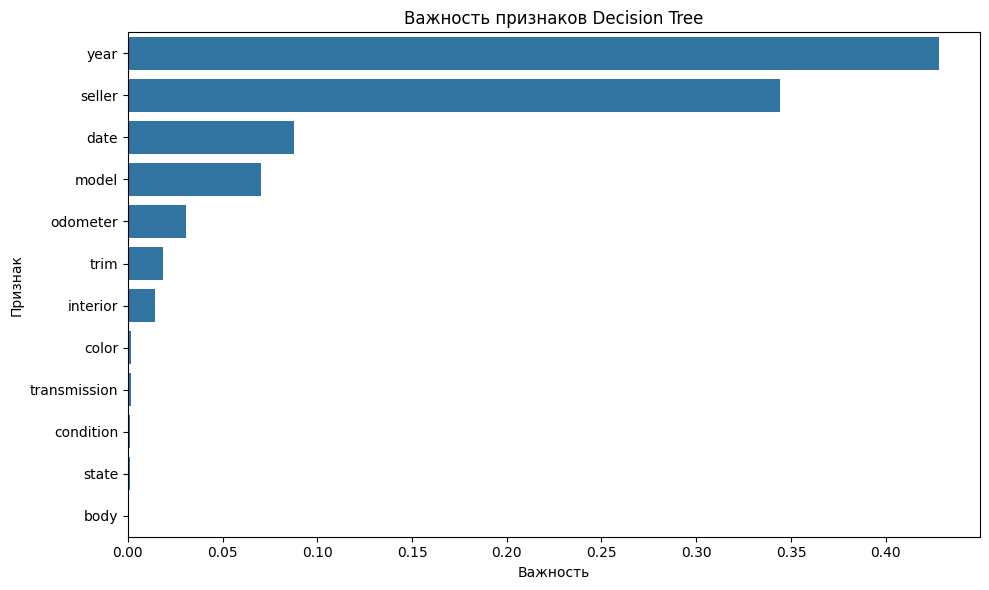

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns

best_model = grid_search.best_estimator_


tree_model = best_model.named_steps['model']  

feature_importances = tree_model.feature_importances_

feature_names = X_train.columns.tolist()

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
}).sort_values('importance', ascending=False)

print("Важность признаков:")

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Важность признаков Decision Tree')
plt.xlabel('Важность')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()

Видим что на цену машины больше всего влияет год выпуска и продавец, что выглядит вполне логично 

### Имплементация  DecisionTree(регрессор)

In [19]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from scipy import stats

class MyDecisionTreeRegressor(BaseEstimator, RegressorMixin):
    class Node:
        def __init__(self, feature_index=None, threshold=None, left=None, right=None,
                    value=None, impurity=None, n_samples=None, depth=0):
            self.feature_index = feature_index 
            self.threshold = threshold      
            self.left = left                    
            self.right = right                
            self.value = value                  
            self.impurity = impurity          
            self.n_samples = n_samples          
            self.depth = depth               
            
        def is_leaf(self):
            return self.value is not None
    
    def __init__(self, criterion='squared_error', max_depth=None, min_samples_split=2,
                 min_samples_leaf=1, min_impurity_decrease=0.0,
                 max_features=None, random_state=None, min_weight_fraction_leaf=0.0,
                 ccp_alpha=0.0, monotonic_cst=None):

        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_impurity_decrease = min_impurity_decrease
        self.max_features = max_features
        self.random_state = random_state
        self.min_weight_fraction_leaf = min_weight_fraction_leaf
        self.ccp_alpha = ccp_alpha
        self.monotonic_cst = monotonic_cst
        
        self.root = None
        self.n_features_in_ = None
        self.feature_importances_ = None
        self.n_outputs_ = None
        self.max_features_ = None
        
    def _check_params(self, n_features):
        if self.criterion not in ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']:
            raise ValueError(f"criterion must be 'squared_error', 'friedman_mse', 'absolute_error' or 'poisson', got {self.criterion}")
            
        if self.max_depth is not None and self.max_depth <= 0:
            raise ValueError(f"max_depth must be > 0, got {self.max_depth}")
            
        if self.min_samples_split < 2:
            raise ValueError(f"min_samples_split must be >= 2, got {self.min_samples_split}")
            
        if self.min_samples_leaf < 1:
            raise ValueError(f"min_samples_leaf must be >= 1, got {self.min_samples_leaf}")
            
        if self.max_features is None:
            self.max_features_ = n_features
        elif isinstance(self.max_features, str):
            if self.max_features == 'sqrt':
                self.max_features_ = int(np.sqrt(n_features))
            elif self.max_features == 'log2':
                self.max_features_ = int(np.log2(n_features))
            else:
                raise ValueError(f"Unknown max_features string: {self.max_features}")
        elif isinstance(self.max_features, int):
            self.max_features_ = min(self.max_features, n_features)
        elif isinstance(self.max_features, float):
            self.max_features_ = max(1, int(self.max_features * n_features))
        else:
            raise ValueError(f"Invalid max_features: {self.max_features}")
            
        if self.random_state is not None:
            np.random.seed(self.random_state)
            
        if self.min_weight_fraction_leaf < 0 or self.min_weight_fraction_leaf > 0.5:
            raise ValueError(f"min_weight_fraction_leaf must be in [0, 0.5], got {self.min_weight_fraction_leaf}")
            
        if self.ccp_alpha < 0:
            raise ValueError(f"ccp_alpha must be >= 0, got {self.ccp_alpha}")
    
    def _compute_impurity(self, y):
        n_samples = len(y)
        if n_samples == 0:
            return 0
            
        if self.criterion == 'squared_error' or self.criterion == 'friedman_mse':
            mean_y = np.mean(y)
            return np.mean((y - mean_y) ** 2)
            
        elif self.criterion == 'absolute_error':
            median_y = np.median(y)
            return np.mean(np.abs(y - median_y))
            
        elif self.criterion == 'poisson':
            mean_y = np.mean(y)
            mean_y = np.maximum(mean_y, 1e-10)
            return 2 * np.mean(y * np.log(y / mean_y) - (y - mean_y))
    
    def _compute_node_value(self, y):
        if self.criterion == 'squared_error' or self.criterion == 'friedman_mse' or self.criterion == 'poisson':
            return np.mean(y)
        elif self.criterion == 'absolute_error':
            return np.median(y)
    
    def _best_split(self, X, y):
        n_samples, n_features = X.shape
        
        if n_samples < self.min_samples_split:
            return None, None
            
        current_impurity = self._compute_impurity(y)
        if current_impurity == 0:
            return None, None
            
        best_gain = 0.0
        best_feature = None
        best_threshold = None
        
        if self.max_features_ < n_features:
            features = np.random.choice(n_features, self.max_features_, replace=False)
        else:
            features = range(n_features)
        
        for feature_index in features:
            feature_values = X[:, feature_index]
            
            unique_values = np.unique(feature_values)
            if len(unique_values) <= 1:
                continue
                
            thresholds = []
            for i in range(len(unique_values) - 1):
                thresholds.append((unique_values[i] + unique_values[i + 1]) / 2)
            
            for threshold in thresholds:
                left_mask = feature_values <= threshold
                right_mask = ~left_mask
                
                n_left = np.sum(left_mask)
                n_right = np.sum(right_mask)
                
                if n_left < self.min_samples_leaf or n_right < self.min_samples_leaf:
                    continue
                
                if (n_left < self.min_weight_fraction_leaf * n_samples or 
                    n_right < self.min_weight_fraction_leaf * n_samples):
                    continue
                
                if self.monotonic_cst is not None:
                    constraint = self.monotonic_cst[feature_index]
                    if constraint != 0:
                        left_mean = np.mean(y[left_mask]) if n_left > 0 else 0
                        right_mean = np.mean(y[right_mask]) if n_right > 0 else 0
                        
                        if constraint == 1: 
                            if left_mean > right_mean:
                                continue
                        elif constraint == -1:  
                            if left_mean < right_mean:
                                continue
                
                y_left = y[left_mask]
                y_right = y[right_mask]
                
                impurity_left = self._compute_impurity(y_left)
                impurity_right = self._compute_impurity(y_right)
                
                weighted_impurity = (n_left * impurity_left + n_right * impurity_right) / n_samples
                
                gain = current_impurity - weighted_impurity
                
                if gain > best_gain and gain >= self.min_impurity_decrease:
                    best_gain = gain
                    best_feature = feature_index
                    best_threshold = threshold
        
        return best_feature, best_threshold
    
    def _grow_tree(self, X, y, depth=0):
        n_samples = X.shape[0]
        
        node_value = self._compute_node_value(y)
        current_impurity = self._compute_impurity(y)
        
        stop_conditions = [
            (self.max_depth is not None and depth >= self.max_depth),
            (n_samples < self.min_samples_split),
            (current_impurity == 0),
            (n_samples < 2 * self.min_samples_leaf)
        ]
        
        if any(stop_conditions):
            return self.Node(
                value=node_value,
                impurity=current_impurity,
                n_samples=n_samples,
                depth=depth
            )
        
        best_feature, best_threshold = self._best_split(X, y)
        
        if best_feature is None:
            return self.Node(
                value=node_value,
                impurity=current_impurity,
                n_samples=n_samples,
                depth=depth
            )
        
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        
        X_left, y_left = X[left_mask], y[left_mask]
        X_right, y_right = X[right_mask], y[right_mask]
        
        if len(y_left) < self.min_samples_leaf or len(y_right) < self.min_samples_leaf:
            return self.Node(
                value=node_value,
                impurity=current_impurity,
                n_samples=n_samples,
                depth=depth
            )
        
        left_subtree = self._grow_tree(X_left, y_left, depth + 1)
        right_subtree = self._grow_tree(X_right, y_right, depth + 1)
        
        return self.Node(
            feature_index=best_feature,
            threshold=best_threshold,
            left=left_subtree,
            right=right_subtree,
            impurity=current_impurity,
            n_samples=n_samples,
            depth=depth
        )
    
    def _compute_feature_importances(self, node):
        if node.is_leaf():
            return
            
        gain = node.impurity - (
            (node.left.n_samples / node.n_samples) * node.left.impurity +
            (node.right.n_samples / node.n_samples) * node.right.impurity
        )
        
        self.feature_importances_[node.feature_index] += gain * node.n_samples
        
        self._compute_feature_importances(node.left)
        self._compute_feature_importances(node.right)
    
    def _apply_cost_complexity_pruning(self, node):
        if node.is_leaf():
            return node, 0
        
        pruned_left, left_impurity = self._apply_cost_complexity_pruning(node.left)
        pruned_right, right_impurity = self._apply_cost_complexity_pruning(node.right)
        
        children_impurity = (
            (node.left.n_samples / node.n_samples) * left_impurity +
            (node.right.n_samples / node.n_samples) * right_impurity
        )
        
        if node.left.is_leaf() and node.right.is_leaf():
            leaf_value = (node.left.value * node.left.n_samples + 
                         node.right.value * node.right.n_samples) / node.n_samples
            leaf_impurity = self._compute_impurity(np.concatenate([
                np.full(node.left.n_samples, node.left.value),
                np.full(node.right.n_samples, node.right.value)
            ]))
        else:
            leaf_value = self._compute_node_value(
                np.concatenate([
                    np.full(node.left.n_samples, node.left.value) if node.left.is_leaf() else 
                    np.full(node.left.n_samples, self._get_leaf_value(node.left)),
                    np.full(node.right.n_samples, node.right.value) if node.right.is_leaf() else 
                    np.full(node.right.n_samples, self._get_leaf_value(node.right))
                ])
            )
            leaf_impurity = node.impurity
        
        node_complexity = 1  
        
        if self.ccp_alpha > 0:
            pruning_gain = children_impurity + self.ccp_alpha * 2 - (leaf_impurity + self.ccp_alpha * 1)
            
            if pruning_gain <= 0:
                return self.Node(
                    value=leaf_value,
                    impurity=leaf_impurity,
                    n_samples=node.n_samples,
                    depth=node.depth
                ), leaf_impurity
        
        node.left = pruned_left
        node.right = pruned_right
        return node, children_impurity
    
    def _get_leaf_value(self, node):
        if node.is_leaf():
            return node.value
        return (self._get_leaf_value(node.left) + self._get_leaf_value(node.right)) / 2
    
    def fit(self, X, y):
       
        X, y = check_X_y(X, y, y_numeric=True)
        
        self.n_features_in_ = X.shape[1]
        self.n_outputs_ = 1  
        
        self._check_params(self.n_features_in_)
        
        self.feature_importances_ = np.zeros(self.n_features_in_)
        
        self.root = self._grow_tree(X, y)
        
        if self.ccp_alpha > 0:
            self.root, _ = self._apply_cost_complexity_pruning(self.root)
        
        self._compute_feature_importances(self.root)
        
        if self.feature_importances_.sum() > 0:
            self.feature_importances_ /= self.feature_importances_.sum()
        
        return self
    
    def _predict_sample(self, x, node):
        if node.is_leaf():
            return node.value
        
        if x[node.feature_index] <= node.threshold:
            return self._predict_sample(x, node.left)
        else:
            return self._predict_sample(x, node.right)
    
    def predict(self, X):
       
        check_is_fitted(self, 'root')
        X = check_array(X)
        
        predictions = []
        for x in X:
            pred = self._predict_sample(x, self.root)
            predictions.append(pred)
            
        return np.array(predictions)

    def get_depth(self):
        check_is_fitted(self, 'root')
        return self._get_node_depth(self.root)
    
    def _get_node_depth(self, node):
        if node.is_leaf():
            return node.depth
        return max(self._get_node_depth(node.left), self._get_node_depth(node.right))
    
    def get_n_leaves(self):
        check_is_fitted(self, 'root')
        return self._count_leaves(self.root)
    
    def _count_leaves(self, node):
        if node.is_leaf():
            return 1
        return self._count_leaves(node.left) + self._count_leaves(node.right)
    
    def get_params(self, deep=True):
        return {
            'criterion': self.criterion,
            'max_depth': self.max_depth,
            'min_samples_split': self.min_samples_split,
            'min_samples_leaf': self.min_samples_leaf,
            'min_impurity_decrease': self.min_impurity_decrease,
            'max_features': self.max_features,
            'random_state': self.random_state,
            'min_weight_fraction_leaf': self.min_weight_fraction_leaf,
            'ccp_alpha': self.ccp_alpha,
            'monotonic_cst': self.monotonic_cst
        }
    
    def set_params(self, **params):
        for param, value in params.items():
            setattr(self, param, value)
        return self
    
    def apply(self, X):
       
        check_is_fitted(self, 'root')
        X = check_array(X)
        
        indices = []
        for x in X:
            leaf_id = self._apply_sample(x, self.root)
            indices.append(leaf_id)
            
        return np.array(indices)
    
    def _apply_sample(self, x, node, leaf_id=0):
        if node.is_leaf():
            return leaf_id
        
        if x[node.feature_index] <= node.threshold:
            return self._apply_sample(x, node.left, leaf_id * 2 + 1)
        else:
            return self._apply_sample(x, node.right, leaf_id * 2 + 2)
    
    def decision_path(self, X):
       
        from scipy.sparse import csr_matrix
        check_is_fitted(self, 'root')
        X = check_array(X)
        
        paths = []
        for x in X:
            path = self._decision_path_sample(x, self.root)
            paths.append(path)
        
        n_samples = len(X)
        n_nodes = self._count_nodes(self.root)
        
        data = []
        rows = []
        cols = []
        
        for i, path in enumerate(paths):
            for node_id in path:
                data.append(1)
                rows.append(i)
                cols.append(node_id)
        
        return csr_matrix((data, (rows, cols)), shape=(n_samples, n_nodes))
    
    def _decision_path_sample(self, x, node, node_id=0, path=None):
        if path is None:
            path = []
        
        path.append(node_id)
        
        if node.is_leaf():
            return path
        
        if x[node.feature_index] <= node.threshold:
            return self._decision_path_sample(x, node.left, node_id * 2 + 1, path)
        else:
            return self._decision_path_sample(x, node.right, node_id * 2 + 2, path)
    
    def _count_nodes(self, node):
        if node.is_leaf():
            return 1
        return 1 + self._count_nodes(node.left) + self._count_nodes(node.right)
    
   

In [21]:
cat_cols = list(X_train.select_dtypes(include=object).columns) 
float_cols = list(X_train.select_dtypes(include=float).columns)
int_cols = list(X_train.select_dtypes(include=int).columns)
num_cols = float_cols + int_cols

In [23]:
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', TargetEncoder(cols=cat_cols, smoothing=100), cat_cols),
    ]
)

my_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', MyDecisionTreeRegressor(
        criterion='squared_error',
        max_depth=None, 
        min_samples_split=20,
        min_samples_leaf=4,
        min_impurity_decrease=0.0,
        max_features=None,
        random_state=42,  
        ccp_alpha=0.0
    ))
])

my_pipeline.fit(X_train, y_train)

y_pred_my = my_pipeline.predict(X_test)



In [29]:
print_metrics(y_test, y_pred_my)

          R²:   0.7672
         MAE:  2909.40
        MAPE:   48.01%
       MdAPE:   16.06%
   Max Error: 103460.00
Mean Residual:   -10.30
Std Residual:  4706.04


Результаты не очень, видим что нам не удалось достигнуть таких же метрик, скорее всего разница в специфике реализации дерева в skylearn 